****Creating a Synthetic NMR Well-log from Conventional Logs with Machine Learning****  
*By Amalendu Das*  

**Definition of NMR:**

*Nuclear Magnetic Resonance (NMR) is a geophysical technique used to analyze the internal structure of rocks and sediments. NMR measures the magnetic properties of atomic nuclei, particularly hydrogen, within a sample. This data provides insights into pore size distribution, fluid saturation, and permeability of geological formations, which is crucial for understanding subsurface properties such as porosity and permeability. In the context of well logging, the NMR log can provide valuable information about the variation of pore sizes within the rock layers.*

**About the Project**


The project aims to predict a missing NMR well log by utilizing other well logs that are available. Specifically, the objective is to predict the NMR log from the Gamma Ray (GR) log, Caliper log, Resistivity log, and the interpreted porosity log in one well located in Atwater Valley, Gulf of Mexico. The model developed for this purpose is then applied to predict the NMR log of a different well in the same region, which is significant for studying methane hydrate deposits.

The two wells in question are located in the Atwater Valley Block 13 (AT-13) and Block 14 (AT-14). These wells were drilled and logged during Leg I of the U.S. Department of Energy/Chevron Gas Hydrate Joint Industry Project (JIP) in 2005. The raw well log data for AT-13 and AT-14 are available for analysis, as well as the processed well logs used in the project for both sites. The project’s aim is to use machine learning tools to construct a model that predicts the missing NMR log by utilizing the available logs for one well and applying it to predict the NMR log in another well located nearby.


### **Approach**  

To effectively characterize the Nuclear Magnetic Resonance (NMR) data, the relaxation time distribution from the NMR log was transformed into two statistical parameters: **Mean of T2 (MLT2)** and **Standard Deviation of T2 (SDT2)**. These two derived metrics serve as the response features that the model aims to predict. The predictor variables include other available well logs: **Gamma Ray (GR)**, **Caliper**, **Resistivity**, and the **interpreted porosity**.  

1. **Initial Data Exploration**  
   - A preliminary analysis was performed on the well logs to evaluate their individual (univariate) distributions and mutual (bivariate) relationships.  
   - The logs were also visualized with respect to depth to understand their variability and patterns.  

2. **Linear Regression Modeling**  
   - A basic linear regression model was applied to predict both MLT2 and SDT2 using the predictor variables.  
   - The results highlighted the limitations of linear regression due to:  
     - Noise in the data (short-distance variations).  
     - Complex, non-linear relationships between predictor and response variables.  

3. **Feature Standardization**  
   - To mitigate the impact of outliers and the varying units of predictor variables, feature standardization was applied.  
   - This step ensures that all variables contribute equally to the model and enhances the performance of complex algorithms.  
   - Additionally, **feature ranking** was conducted to identify and prioritize the most influential predictors for the response variables.  

4. **Noise Reduction and Advanced Modeling**  
   - The data was pre-processed to reduce noise and improve the quality of input features.  
   - The dataset was split into training and testing subsets to validate the model’s performance.  
   - A **polynomial regression model** was employed to capture the non-linear relationships and achieve a better fit for predicting the NMR log at **Keathley Canyon**.  

5. **Prediction at Walker Ridge**  
   - After successfully training the model using data from Keathley Canyon, it was applied to predict the NMR log at **Walker Ridge**, where NMR data was not recorded.  

---

### **Pre-requisites**  

To execute this workflow, the following software and tools are required:  

1. **Python 3.x**:  
   - A high-level programming language used for implementing the machine learning models and data processing pipelines.  

2. **Anaconda Distribution**:  
   - A comprehensive platform that simplifies package management and deployment.  
   - It includes popular libraries like **NumPy**, **pandas**, **Matplotlib**, and **scikit-learn**, which are essential for data analysis, visualization, and machine learning.  

---

This approach combines statistical transformation, advanced modeling, and rigorous feature engineering to effectively predict missing NMR logs in regions of interest.

### Importing Libraries

In [51]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
import pandas.plotting as pd_plot           # scatter plots
import scipy
from scipy import linalg                 
from scipy import stats                   # summary statistics
import seaborn as sns                     # for matrix scatter plots
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression           # linear regression with scikit learn
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split        
import geostatspy.GSLIB as GSLIB         
import geostatspy.geostats as geostats    # GSLIB methods convert to Python 
from sklearn.preprocessing import StandardScaler

## Loading the data

In [52]:
#Data is in the notebook
at13_log_file_path = os.path.join(os.getcwd(), "AT_13_logs.csv") 
df = pd.read_csv(at13_log_file_path)

In [53]:
#data
df.head(n=12)

,Depth,GR,Porosity,Caliper,Ring resistivity,MLT2_all_original,SD_all_original
0,10.1880,58.1601,0.565722,9.1381,1.0184,2.322000,1.736223
1,10.3404,60.9179,0.558754,8.7842,1.0160,2.283500,1.661481
2,10.4928,61.4844,0.539033,8.7377,1.0135,2.183867,1.578455
3,10.6452,62.4926,0.523800,9.0833,1.0110,2.055333,1.539178
4,10.7976,61.8291,0.519989,9.1003,1.0098,2.003367,1.554955
5,10.9500,60.9953,0.539951,8.9128,1.0104,1.952167,1.592646
6,11.1024,62.3432,0.577547,9.0531,1.0146,1.875300,1.674858
7,11.2548,62.1375,0.589453,8.9236,1.0125,1.792500,1.758866
8,11.4072,65.0147,0.581286,8.6480,1.0119,1.708300,1.864923
9,11.5596,64.1987,0.546441,8.6592,1.0162,1.696233,1.840970


## Statistics
The summary statistics indicate that all variables fall within their anticipated ranges, eliminating the need for truncation or adjustment.

In [54]:
#statistics
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Depth,1313.0,110.162400,57.786234,10.188000,60.175200,110.162400,160.149600,210.136800
GR,1313.0,91.377706,10.425923,58.160100,91.439000,94.501400,96.935500,107.748500
Porosity,1313.0,0.562583,0.027671,0.498539,0.543256,0.560599,0.577846,0.680680
Caliper,1313.0,9.026709,0.623537,8.287300,8.616500,8.869000,9.234400,13.282000
Ring resistivity,1313.0,1.015662,0.055021,0.834900,0.981200,1.027900,1.053600,1.151200
MLT2_all_original,1313.0,1.670002,0.204280,1.247833,1.533967,1.675100,1.792033,2.459400
SD_all_original,1313.0,1.698933,0.174723,1.246480,1.572906,1.689552,1.817860,2.274984


In [55]:
#Defining the minimum and maximum of variables for plotting figures

pormin = df['Porosity'].min(); pormax = df['Porosity'].max(); porname = 'Porosity (v/v)'; portitle = 'Porosity' # user specified min and max values, and labels for plotting
grmin = df['GR'].min(); grmax = df['GR'].max(); grname = 'Gamma Ray (GAPI)'; grtitle = 'Gamma Ray Log' 
calmin = df['Caliper'].min(); calmax = df['Caliper'].max(); calname = 'Caliper (cm)'; caltitle = 'Caliper Log' 
resmin = df['Ring resistivity'].min(); resmax = df['Ring resistivity'].max(); resname = 'Ring resistivity (ohm-m)'; restitle = 'Ring resistivity Log' 
mlt2min = df['MLT2_all_original'].min(); mlt2max = df['MLT2_all_original'].max(); mlt2name = 'Mean Log of T2 (log[ms])'; mlt2title = 'Mean Log of T2 (NMR)'
sdt2min = df['SD_all_original'].min(); sdt2max = df['SD_all_original'].max(); sdt2name = 'Standard Deviation of T2 (log[ms])'; sdt2title = 'Standard Deviation of T2 (NMR)' 
depthmin = df['Depth'].min(); depthmax = df['Depth'].max(); depthname = 'Depth (mbsf)'; depthtitle = 'Depth in meters below sea-floor (mbsf)' 

Plotting well logs

All the well-logs are plotted with depth to see the spatial variation

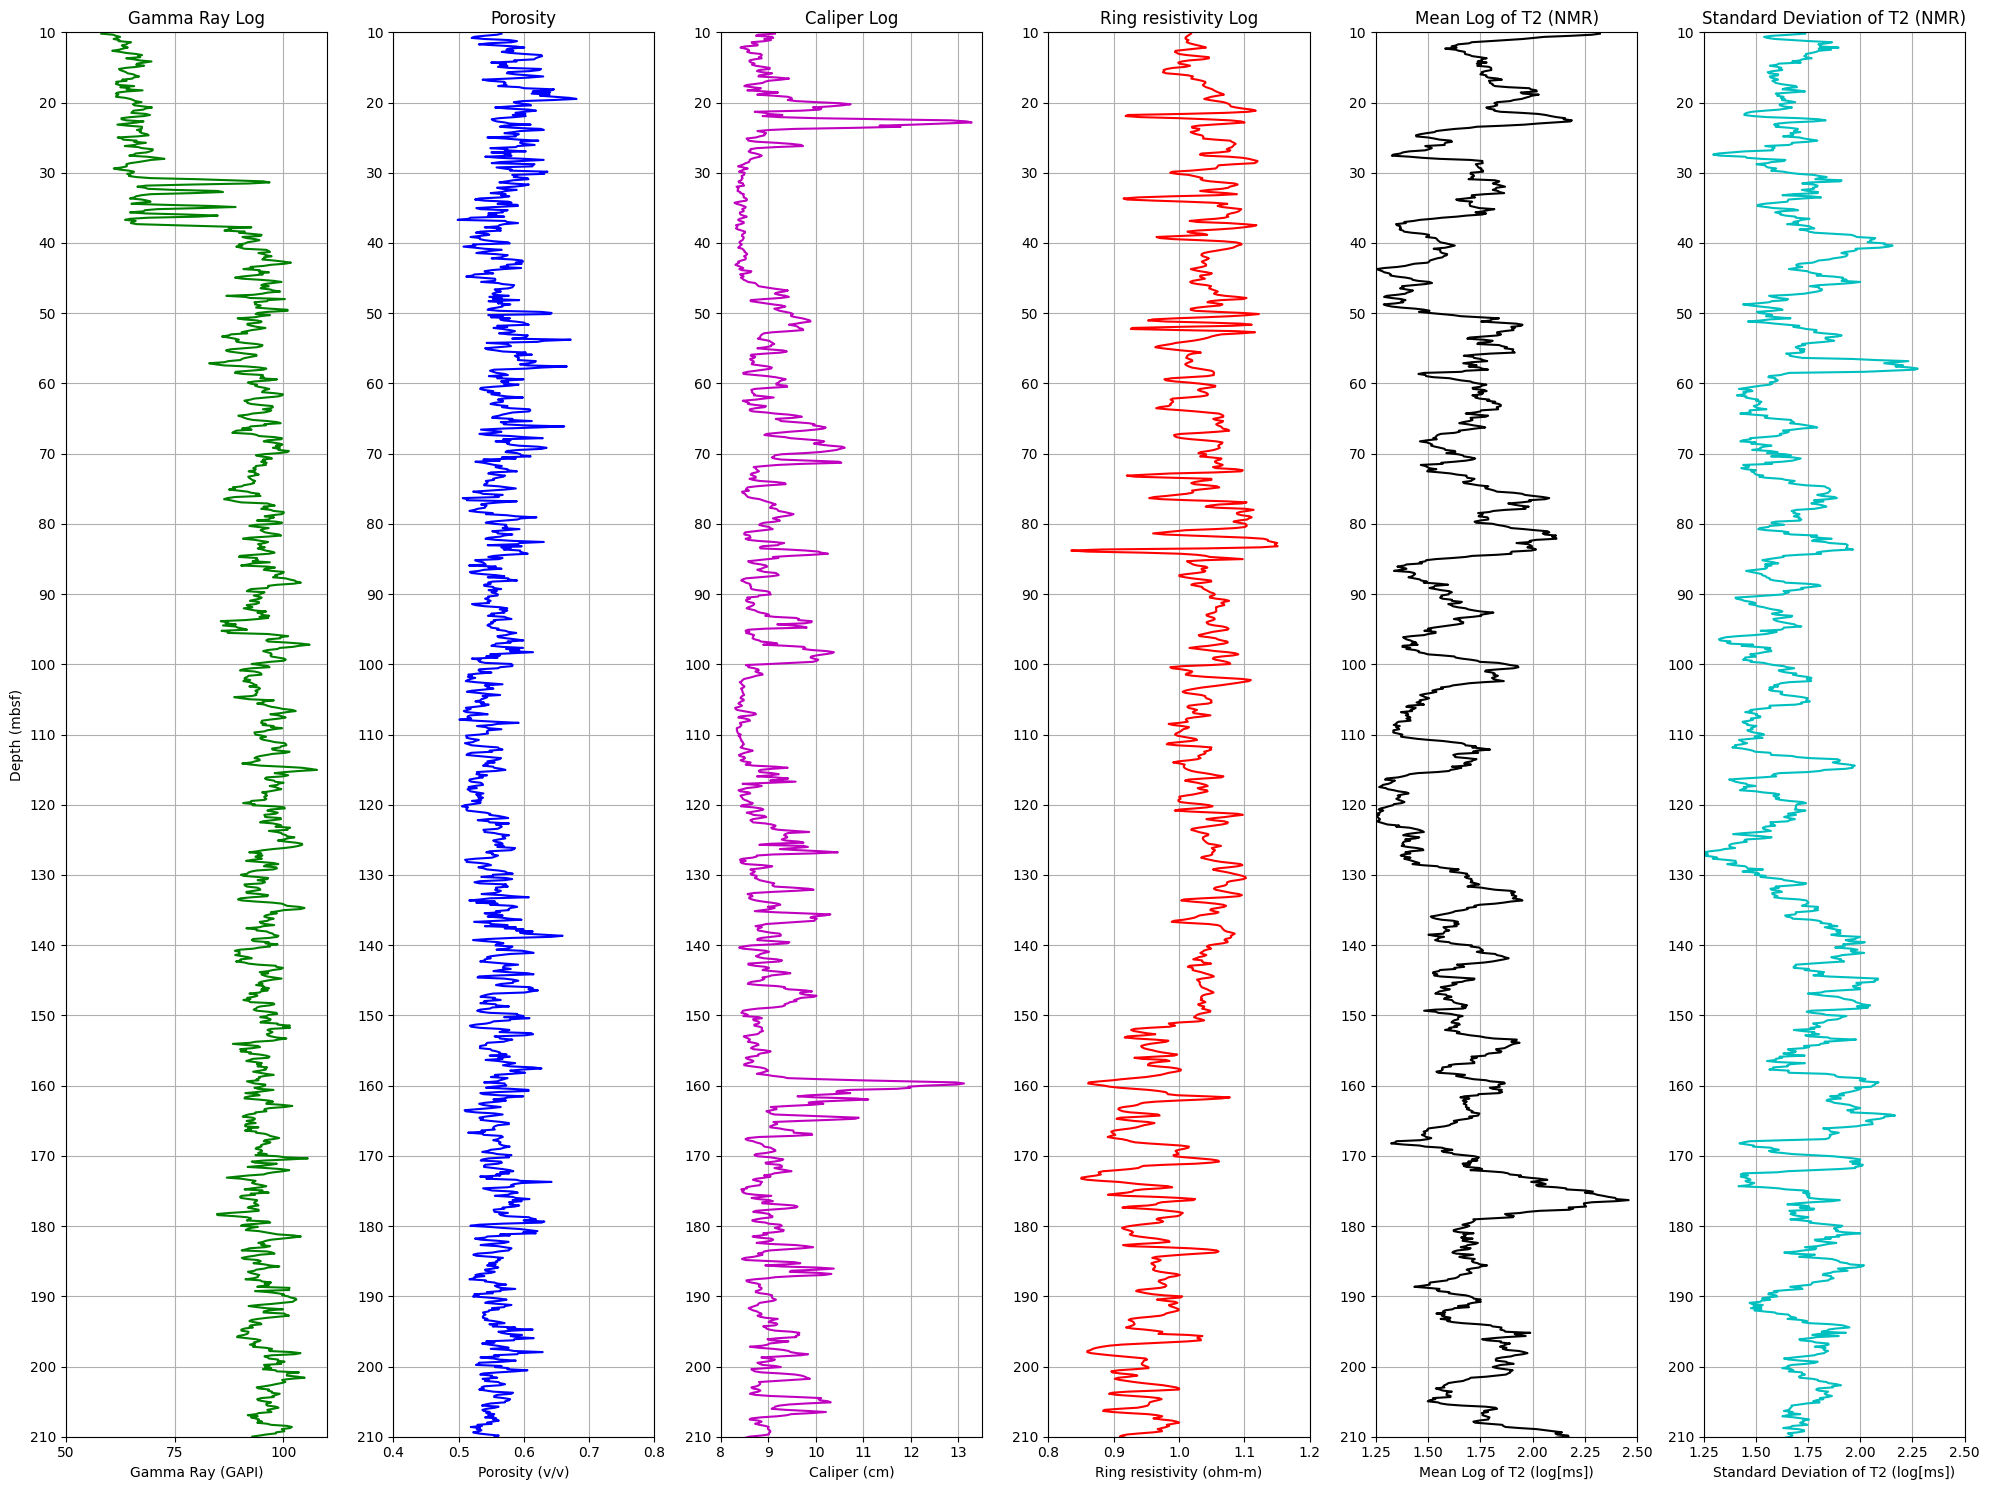

In [59]:
# Plot logs vs depth
plt.figure(figsize=(20, 15))

# Gamma Ray log
plt.subplot(161)
plt.plot(df['GR'].values, df['Depth'].values, 'g')
plt.title(grtitle)
plt.xlabel(grname)
plt.ylabel(depthname)
plt.yticks(np.arange(10, 220, 10))
plt.xticks(np.arange(25, 130, 25))  # Gamma Ray x-axis ticks
plt.xlim(50, 110)  # Set x-axis range for Gamma Ray
plt.grid(True)
plt.gca().invert_yaxis()
plt.ylim(210, 10)  # Adjusted to reflect the depth range
#plt.arrow(25, 105, 50, 0, width=0.5, color='red', head_length=0.0, head_width=0.0)

# Porosity log
plt.subplot(162)
plt.plot(df['Porosity'].values, df['Depth'].values, 'b')
plt.title(portitle)
plt.xlabel(porname)
plt.yticks(np.arange(10, 220, 10))
plt.xlim(0.4, 0.8)  # Adjust x-axis for Porosity (example range, modify if needed)
plt.grid(True)
plt.gca().invert_yaxis()
plt.ylim(210, 10)

# Caliper log
plt.subplot(163)
plt.plot(df['Caliper'].values, df['Depth'].values, 'm')
plt.title(caltitle)
plt.xlabel(calname)
plt.yticks(np.arange(10, 220, 10))
plt.xlim(8, 13.5)  # Adjust x-axis for Caliper (example range, modify if needed)
plt.grid(True)
plt.gca().invert_yaxis()
plt.ylim(210, 10)

# Ring Resistivity log
plt.subplot(164)
plt.plot(df['Ring resistivity'].values, df['Depth'].values, 'r')
plt.title(restitle)
plt.xlabel(resname)
plt.yticks(np.arange(10, 220, 10))
plt.xlim(0.8, 1.2)  # Adjust x-axis for Resistivity (example range, modify if needed)
plt.grid(True)
plt.gca().invert_yaxis()
plt.ylim(210, 10)

# MLT2 log
plt.subplot(165)
plt.plot(df['MLT2_all_original'].values, df['Depth'].values, 'k')
plt.title(mlt2title)
plt.xlabel(mlt2name)
plt.yticks(np.arange(10, 220, 10))
plt.xlim(1.25, 2.5)  # Adjust x-axis for MLT2 (example range, modify if needed)
plt.grid(True)
plt.gca().invert_yaxis()
plt.ylim(210, 10)

# SD log
plt.subplot(166)
plt.plot(df['SD_all_original'].values, df['Depth'].values, 'c')
plt.title(sdt2title)
plt.xlabel(sdt2name)
plt.yticks(np.arange(10, 220, 10))
plt.xlim(1.25, 2.5)  # Adjust x-axis for SD (example range, modify if needed)
plt.grid(True)
plt.gca().invert_yaxis()
plt.ylim(210, 10)

plt.tight_layout()
plt.show()


### NMR Log Variables

The NMR log provides essential insights into subsurface formations by measuring various properties at different depths. One key parameter derived from the measured NMR log is the **transverse relaxation time (T2)**, which captures the varying amplitudes of T2 values depending on the formation characteristics and the fluids present at a specific depth. 

To simplify the interpretation and analysis of the NMR data, the relaxation time distribution was transformed into two key statistical measures: the **Mean (MLT2)** and the **Standard Deviation (SDT2)**, both derived after applying a logarithmic transformation. These parameters help in characterizing the subsurface more effectively by condensing complex distributions into meaningful metrics.

Although the relaxation time distributions are often depicted as normal distributions for ease of visualization, they may deviate significantly from this assumption in real-world scenarios due to the heterogeneity of formations and fluid properties. This highlights the importance of advanced processing techniques to extract reliable information from the NMR data. 

By utilizing MLT2 and SDT2, geoscientists can gain deeper insights into pore size distributions, fluid saturations, and permeability variations within the subsurface, which are critical for reservoir characterization and development planning.

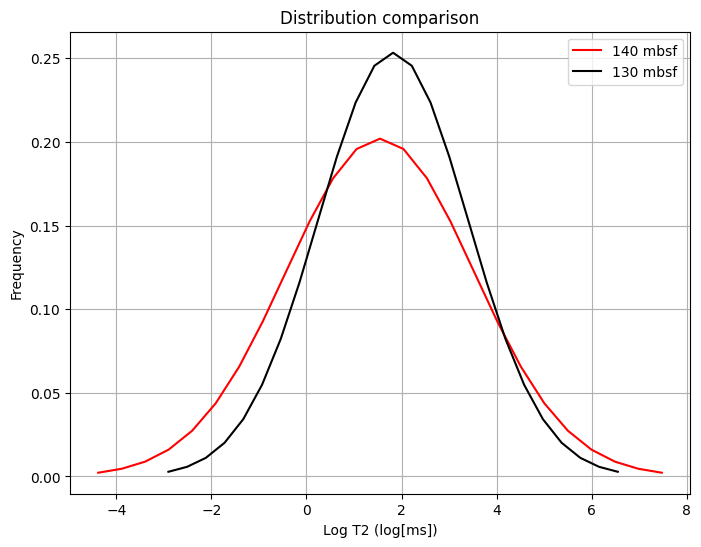

In [61]:
# low MLT2 and high SDT2
MLT2_140 = df.loc[(df['Depth'] > 139) & (df['Depth'] < 139.2), 'MLT2_all_original']
SDT2_140 = df.loc[(df['Depth'] > 139) & (df['Depth'] < 139.2), 'SD_all_original']

# high MLT2 and low SDT2
MLT2_130 = df.loc[(df['Depth'] > 132) & (df['Depth'] < 132.2), 'MLT2_all_original']
SDT2_130 = df.loc[(df['Depth'] > 132) & (df['Depth'] < 132.2), 'SD_all_original']

# Plotting distributions
x = np.linspace(MLT2_140 - 3*SDT2_140, MLT2_140 + 3*SDT2_140, 25)
plt.plot(x, stats.norm.pdf(x, MLT2_140, SDT2_140), 'r', label='140 mbsf')

x1 = np.linspace(MLT2_130 - 3*SDT2_130, MLT2_130 + 3*SDT2_130, 25)
plt.plot(x1, stats.norm.pdf(x1, MLT2_130, SDT2_130), 'k', label='130 mbsf')

plt.title('Distribution comparison')
plt.xlabel('Log T2 (log[ms])')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.gcf().set_size_inches(8, 6)
plt.show()


In [62]:
#Updating the minimum and maximum of variables for plotting figures.
pormin = df['Porosity'].min(); pormax = df['Porosity'].max(); porname = 'Porosity (v/v)'; portitle = 'Porosity' # user specified min and max values, and labels for plotting
grmin = df['GR'].min(); grmax = df['GR'].max(); grname = 'Gamma Ray (GAPI)'; grtitle = 'Gamma Ray Log' 
calmin = df['Caliper'].min(); calmax = df['Caliper'].max(); calname = 'Caliper (cm)'; caltitle = 'Caliper Log' 
resmin = df['Ring resistivity'].min(); resmax = df['Ring resistivity'].max(); resname = 'Ring resistivity (ohm-m)'; restitle = 'Ring resistivity Log' 
mlt2min = df['MLT2_all_original'].min(); mlt2max = df['MLT2_all_original'].max(); mlt2name = 'Mean Log of T2 (log[ms])'; mlt2title = 'Mean Log of T2 (NMR)' 
sdt2min = df['SD_all_original'].min(); sdt2max = df['SD_all_original'].max(); sdt2name = 'Standard Deviation of T2 (log[ms])'; sdt2title = 'Standard Deviation of T2 (NMR)' 
depthmin = df['Depth'].min(); depthmax = df['Depth'].max(); depthname = 'Depth (mbsf)'; depthtitle = 'Depth in meters below sea-floor (mbsf)' 

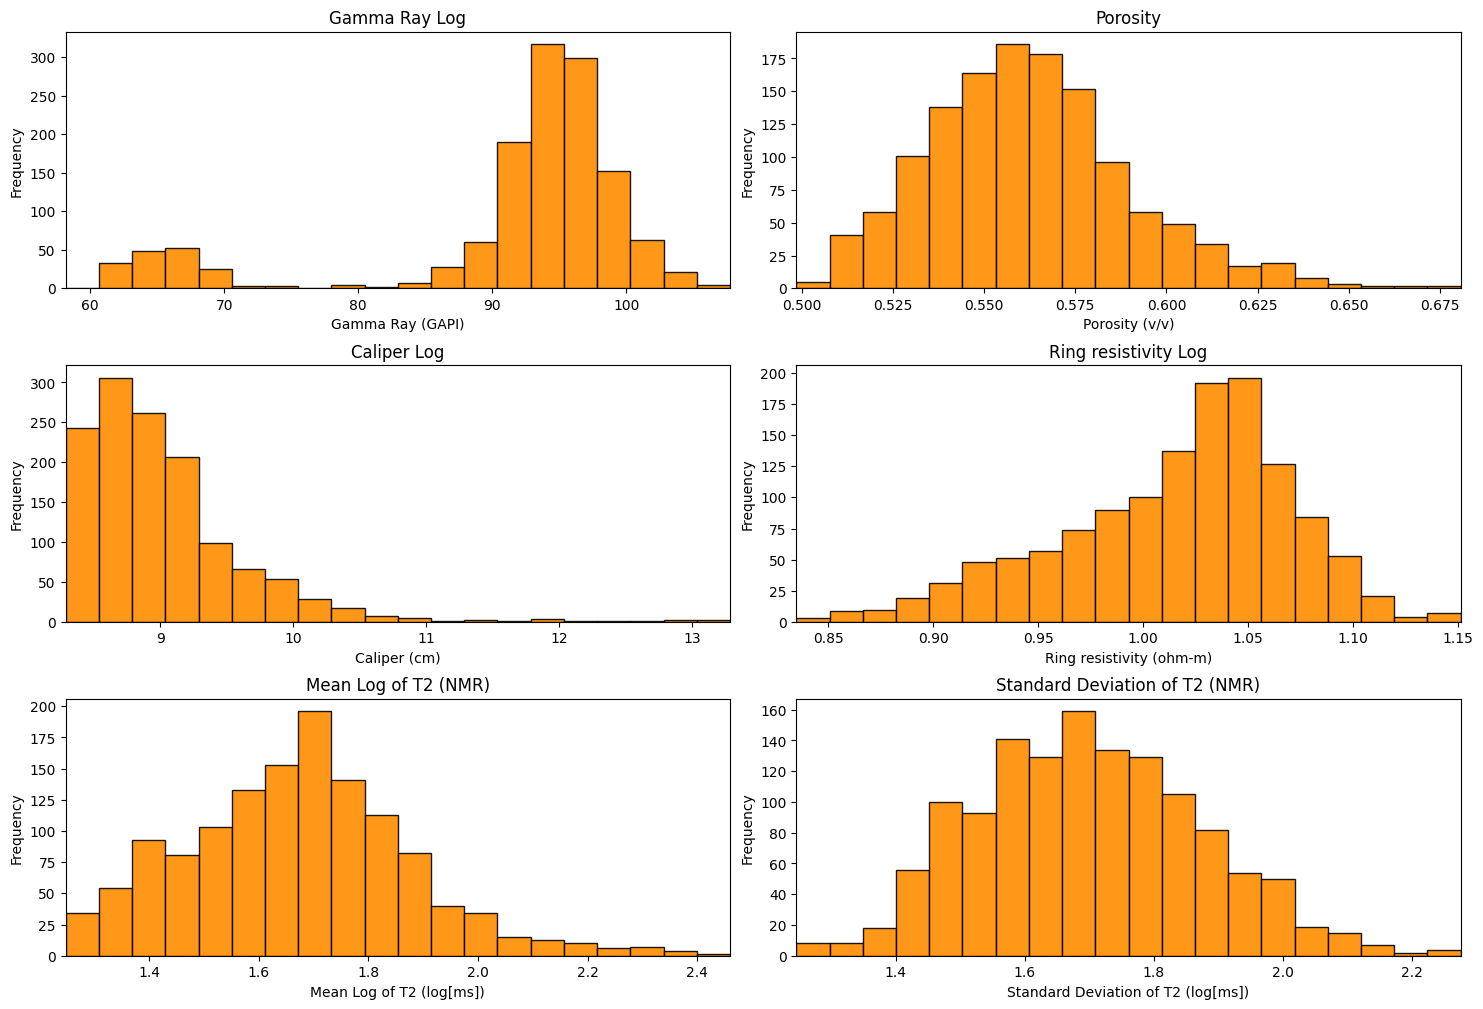

In [63]:
#Plotting univariate distributions

plt.subplot(321)
GSLIB.hist_st(df['GR'].values, grmin, grmax, log=False, cumul = False,bins=20, weights = None, xlabel=grname, title=grtitle)

plt.subplot(322)
GSLIB.hist_st(df['Porosity'].values,pormin,pormax,log=False,cumul = False,bins=20,weights = None,xlabel=porname,title=portitle)

plt.subplot(323)
GSLIB.hist_st(df['Caliper'].values,calmin,calmax,log=False,cumul = False,bins=20,weights = None,xlabel=calname,title=caltitle)

plt.subplot(324)
GSLIB.hist_st(df['Ring resistivity'].values,resmin,resmax,log=False,cumul = False,bins=20,weights = None, xlabel=resname, title=restitle)

plt.subplot(325)
GSLIB.hist_st(df['MLT2_all_original'].values,mlt2min,mlt2max,log=False,cumul = False,bins=20,weights = None, xlabel=mlt2name,title=mlt2title)

plt.subplot(326)
GSLIB.hist_st(df['SD_all_original'].values,sdt2min,sdt2max,log=False,cumul = False,bins=20,weights = None, xlabel=sdt2name,title=sdt2title)


plt.subplots_adjust(wspace=0.1, hspace=0.3)

plt.gcf().set_size_inches(18, 12)
#plt.savefig('hist_Porosity_Multiple_bins.tif',dpi=600,bbox_inches="tight")
plt.show()

### **Plotting Bivariate Distributions**  

The bivariate distribution analysis reveals intricate relationships between the various variables, indicating non-linear dependencies. However, the plot showing the relationship between **Mean of T2 (MLT2)** and **Standard Deviation of T2 (SDT2)** can be disregarded. This is because a strong and well-established correlation already exists between these two metrics, rendering further analysis unnecessary for this particular pair.

<Figure size 2000x2000 with 0 Axes>

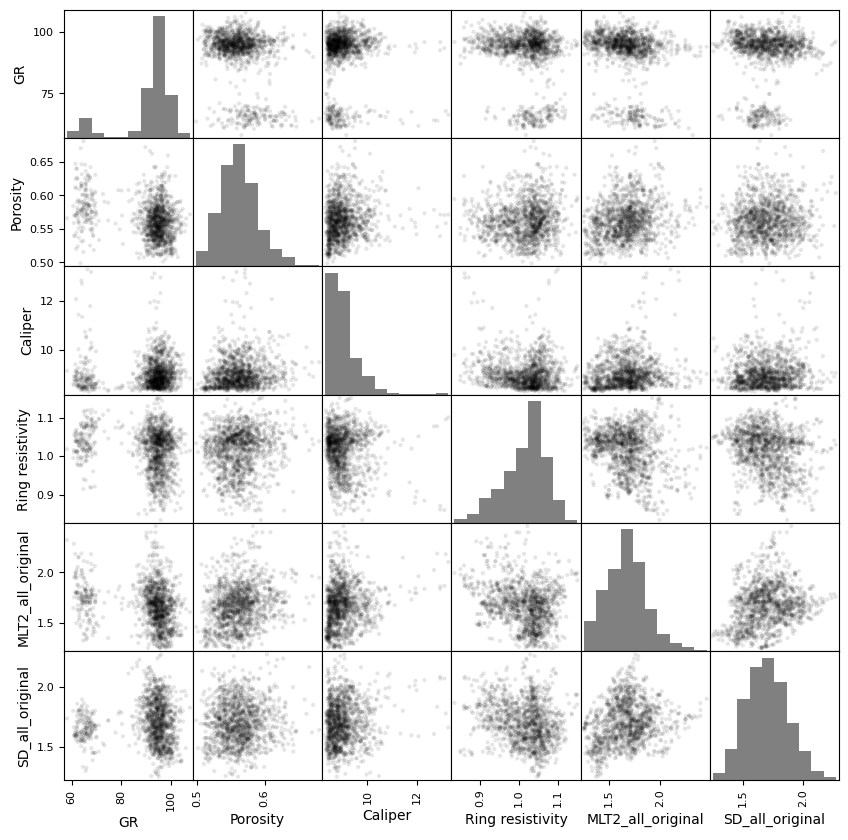

In [64]:
#Plotting bivariate distributions

plt.figure(figsize=(20,20)) 
pd_plot.scatter_matrix(df.drop('Depth', axis = 1), alpha = 0.1,              # pandas matrix scatter plot
    figsize=(6, 6),color = 'black', hist_kwds={'color':['grey']})
plt.gcf().set_size_inches(10, 10)
plt.show()

### **Linear Regression**  

As an initial step, a linear regression model was applied to predict **Mean of T2 (MLT2)** and **Standard Deviation of T2 (SDT2)** using the available predictor variables (Gamma Ray, Caliper, Resistivity, and interpreted porosity). This approach provides a baseline understanding of how the predictor features individually and collectively influence the response variables.  

The linear regression serves as a simple and interpretable model to evaluate whether the relationships between the predictors and the responses can be adequately captured by linear trends. However, it was observed that the linear model struggled to accurately represent the behavior of MLT2 and SDT2 due to the inherent noise in the data and the complex, non-linear nature of the relationships. This underscored the need for more advanced modeling techniques to improve prediction accuracy.

In [65]:
#linear regression for MLT2 with all data

X1 = df[['GR','Porosity','Caliper','Ring resistivity']] # here we have 4 input variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y1 = df['MLT2_all_original'] # output variable (what we are trying to predict)


lin_reg = LinearRegression() 
lin_reg.fit(X1, Y1) 
MLT2_pred=lin_reg.predict(X1)

print('Coefficient of regression (R2) for MLT2')
r2_score(Y1, MLT2_pred)

Coefficient of regression (R2) for MLT2


0.16808009653630984

In [66]:
#linear regression for SDT2 with all data

X2 = df[['GR', 'Porosity', 'Caliper', 'Ring resistivity']] # here we have 4 input variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y2 = df['SD_all_original'] # output variable (what we are trying to predict)

lin_reg.fit(X2, Y2) 
SDT2_pred=lin_reg.predict(X2)

print('Coefficient of regression (R2) for SDT2')
r2_score(Y2, SDT2_pred)

Coefficient of regression (R2) for SDT2


0.061546343053537456

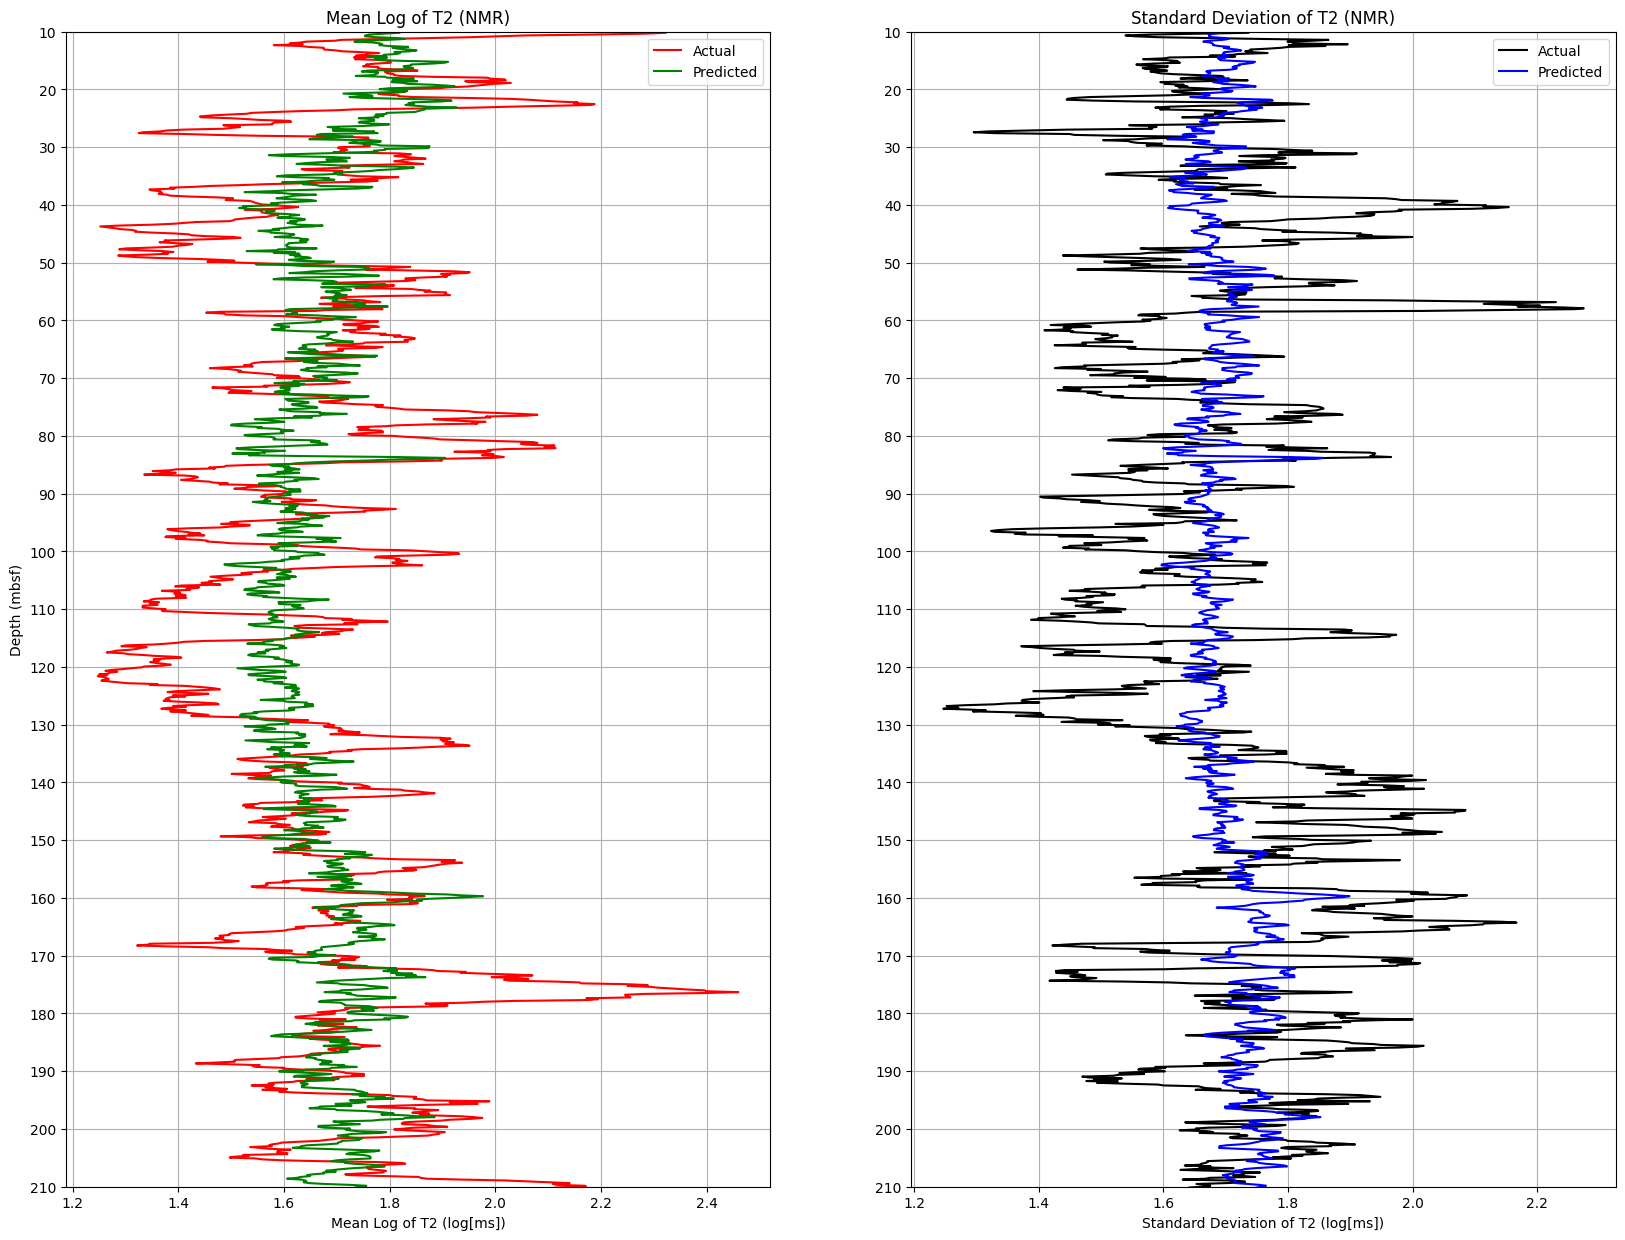

In [67]:
#Comparison between original and predicted MLT2 and SDT2

plt.subplot(121)
plt.plot(df['MLT2_all_original'].values, df['Depth'].values,'r',label='Actual')
plt.plot(MLT2_pred, df['Depth'].values,'g',label='Predicted')
plt.title(mlt2title)
plt.xlabel(mlt2name)
plt.ylabel(depthname)
plt.yticks(np.arange(0, max(df['Depth'].values), 10.0))
plt.grid(True)
plt.gca().set_ylim([10,210])
plt.gca().invert_yaxis()
plt.legend()

plt.subplot(122)
plt.plot(df['SD_all_original'].values, df['Depth'].values,'k',label='Actual')
plt.plot(SDT2_pred, df['Depth'].values,'b',label='Predicted')
plt.title(sdt2title)
plt.xlabel(sdt2name)
plt.yticks(np.arange(0, max(df['Depth'].values), 10.0))
plt.grid(True)
plt.gca().set_ylim([10,210])
plt.gca().invert_yaxis()
plt.legend()

plt.gcf().set_size_inches(20, 15)

In [68]:
#Standardization

scaler = StandardScaler()                     # instantiate the scaler 
dfS = df.copy()
depth=df['Depth']
MLT2=df['MLT2_all_original']
SDT2=df['SD_all_original']
scaler.fit(dfS.drop('Depth',axis=1))
dfS1 = scaler.transform(dfS.drop('Depth', axis = 1)) # standardize all the values extracted from the DataFrame except Depth
transformer_MLT2 = scaler.fit(MLT2.values.reshape(-1, 1))
dfS = pd.DataFrame(dfS1, index = dfS.index, columns = dfS.drop('Depth', axis = 1).columns)
dfS.insert(0, 'Depth', depth)
scaler2 = StandardScaler()                     
transformer_SDT2 = scaler2.fit(SDT2.values.reshape(-1, 1))
dfS.describe()

,Depth,GR,Porosity,Caliper,Ring resistivity,MLT2_all_original,SD_all_original
count,1313.000000,1.313000e+03,1.313000e+03,1.313000e+03,1.313000e+03,1.313000e+03,1.313000e+03
mean,110.162400,-1.688418e-15,1.677595e-15,-1.233844e-15,-1.385369e-15,7.468004e-16,1.082319e-16
std,57.786234,1.000381e+00,1.000381e+00,1.000381e+00,1.000381e+00,1.000381e+00,1.000381e+00
min,10.188000,-3.187273e+00,-2.315344e+00,-1.186281e+00,-3.286573e+00,-2.067400e+00,-2.590539e+00
25%,60.175200,5.881238e-03,-6.987247e-01,-6.581248e-01,-6.265845e-01,-6.661776e-01,-7.215723e-01
50%,110.162400,2.997225e-01,-7.173647e-02,-2.530229e-01,2.225027e-01,2.496574e-02,-5.371311e-02
75%,160.149600,5.332776e-01,5.517812e-01,3.332117e-01,6.897733e-01,5.975994e-01,6.809175e-01
max,210.136800,1.570799e+00,4.269460e+00,6.827036e+00,2.464311e+00,3.865757e+00,3.298198e+00


In [69]:
#Saving variables for inverse scaling
mlt2mean = df['MLT2_all_original'].mean();
mlt2sd = df['MLT2_all_original'].std();
sdt2mean = df['SD_all_original'].mean();
sdt2sd = df['SD_all_original'].std();

<Figure size 2000x2000 with 0 Axes>

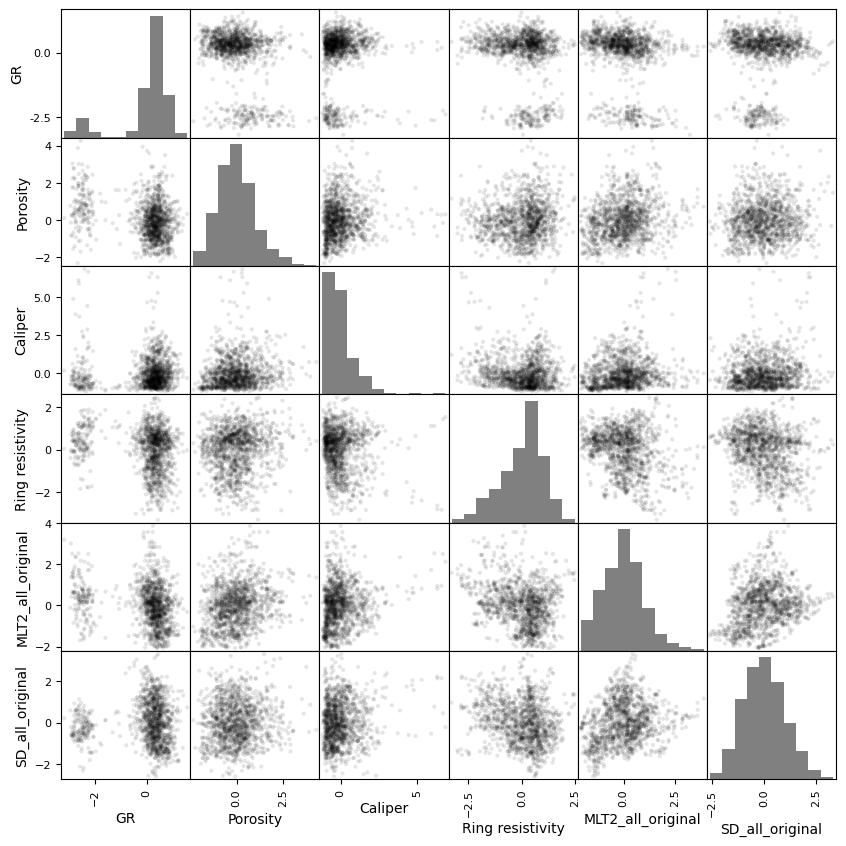

In [70]:
#Plotting bivariate distributions

plt.figure(figsize=(20,20)) 
pd_plot.scatter_matrix(dfS.drop('Depth', axis = 1), alpha = 0.1,              # pandas matrix scatter plot
    figsize=(6, 6),color = 'black', hist_kwds={'color':['grey']})
plt.gcf().set_size_inches(10, 10)
plt.show()

## Covariance

Pairwise covariance provides a measure of the strength of the linear relationship between each predictor feature and the response feature but varies in magnitude according to units. Not seen in this case due to standardization.

In [71]:
#Find covariance
covariance1 = dfS.iloc[:,1:7].cov().iloc[4,:4]
covariance2 = dfS.iloc[:,1:7].cov().iloc[5,:4]

print(covariance1)
print(covariance2)

GR                 -0.216098
Porosity            0.222291
Caliper             0.155388
Ring resistivity   -0.237774
Name: MLT2_all_original, dtype: float64
GR                  0.033666
Porosity            0.069666
Caliper             0.114106
Ring resistivity   -0.217508
Name: SD_all_original, dtype: float64


In [72]:
#Find pairwise correlation coefficient
correlation1 = dfS.iloc[:,1:7].corr().iloc[4,:4]
correlation2 = dfS.iloc[:,1:7].corr().iloc[5,:4]

print(correlation1)
print(correlation2)

GR                 -0.215934
Porosity            0.222122
Caliper             0.155270
Ring resistivity   -0.237593
Name: MLT2_all_original, dtype: float64
GR                  0.033641
Porosity            0.069613
Caliper             0.114019
Ring resistivity   -0.217343
Name: SD_all_original, dtype: float64


In [73]:
#Find Pairwise Spearman rank correlation coefficient
rank_correlation, rank_correlation_pval = stats.spearmanr(dfS.iloc[:,1:7]) # calculate the range correlation coefficient

rank_correlation1 = rank_correlation[:,4][:4]
rank_correlation_pval1 = rank_correlation_pval[:,4][:4]

print('MLT2')
print('rank_correlation')
print(rank_correlation1)
print('rank_correlation_pval')
print(rank_correlation_pval1)

rank_correlation2 = rank_correlation[:,5][:4]
rank_correlation_pval2 = rank_correlation_pval[:,5][:4]
print('SDT2')
print('rank_correlation')
print(rank_correlation2)
print('rank_correlation_pval')
print(rank_correlation_pval2)

MLT2
rank_correlation
[-0.28217277  0.21978259  0.16375318 -0.20239014]
rank_correlation_pval
[1.85705649e-25 7.94798160e-16 2.39691947e-09 1.32704561e-13]
SDT2
rank_correlation
[-0.09846917  0.05338301  0.08436345 -0.22887769]
rank_correlation_pval
[3.52439543e-04 5.31268540e-02 2.21719788e-03 4.56973097e-17]


In [74]:
#Partial Correlation in Python (clone of Matlab's partialcorr)

#This uses the linear regression approach to compute the partial correlation 
#(might be slow for a huge number of variables). The algorithm is detailed here:

# http://en.wikipedia.org/wiki/Partial_correlation#Using_linear_regression

#Taking X and Y two variables of interest and Z the matrix with all the variable minus {X, Y},
#the algorithm can be summarized as
#    1) perform a normal linear least-squares regression with X as the target and Z as the predictor
#    2) calculate the residuals in Step #1
#    3) perform a normal linear least-squares regression with Y as the target and Z as the predictor
#    4) calculate the residuals in Step #3
#    5) calculate the correlation coefficient between the residuals from Steps #2 and #4; 
#    The result is the partial correlation between X and Y while controlling for the effect of Z

#Date: Nov 2014
#Author: Fabian Pedregosa-Izquierdo, f@bianp.net
#Testing: Valentina Borghesani, valentinaborghesani@gmail.com

def partial_corr(C):
#    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
#    for the remaining variables in C.

#    Parameters
#    C : array-like, shape (n, p)
#        Array with the different variables. Each column of C is taken as a variable
#    Returns
#    P : array-like, shape (p, p)
#        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
#        for the remaining variables in C.

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float64)

    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def semipartial_corr(C): # Michael Pyrcz modified the function above by Fabian Pedregosa-Izquierdo, f@bianp.net for semipartial correlation
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float64)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] # just use the value, not a residual
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

#### Partial Correlation Coefficient

Partial Correlation Coefficient is a linear correlation coefficient that controls for the effects all the remaining variables, $\rho_{XY.Z}$ and $\rho_{YX.Z}$ is the partial correlation between $X$ and $Y$, $Y$ and $X$, after controlling for $Z$.

In [75]:
#Find partial correlation

partial_correlation = partial_corr(dfS.iloc[:,1:7]) # calculate the partial correlation coefficients
#print(partial_correlation)
partial_correlation1 = partial_correlation[:,4][:4] # extract a single row and remove with itself
print('MLT2')
print(partial_correlation1)

partial_correlation2 = partial_correlation[:,5][:4] # extract a single row and remove with itself
print('SDT2')
print(partial_correlation2)

MLT2
[-0.22706739  0.15983607  0.10326655 -0.25306814]
SDT2
[ 0.05460608  0.05211598  0.06112684 -0.15672105]


In [76]:
#Find semi-partial correlation

semipartial_correlation = semipartial_corr(dfS.iloc[:,1:7]) # calculate the partial correlation coefficients
#print(partial_correlation)
semipartial_correlation1 = semipartial_correlation[:,4][:4] # extract a single row and remove with itself
print('MLT2')
print(semipartial_correlation1)

semipartial_correlation2 = semipartial_correlation[:,5][:4] # extract a single row and remove with itself
print('SDT2')
print(semipartial_correlation2)

MLT2
[-0.21357578  0.15055325  0.10125837 -0.24141646]
SDT2
[ 0.0500947   0.04852407  0.05972938 -0.1464484 ]


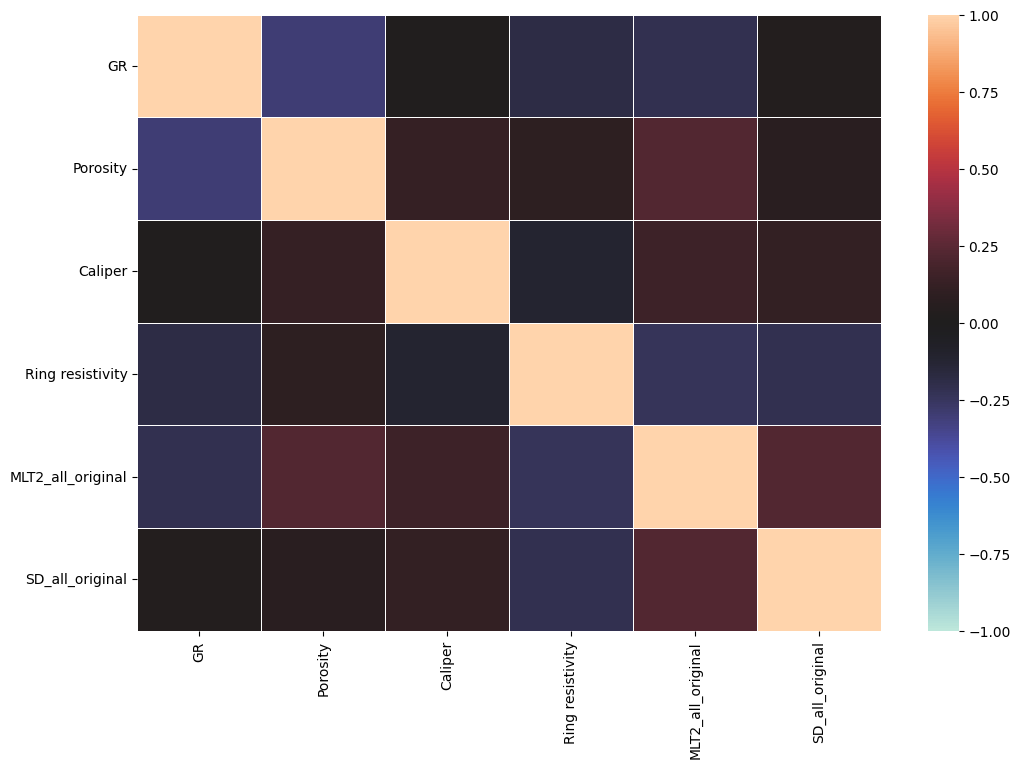

In [78]:
# Color coded correlation matrix

plt.subplot(111)                          # plot a color coded correlation matrix
sns.heatmap(dfS.iloc[:,1:7].corr(),vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f', center=0)

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.gcf().set_size_inches(12, 8)
plt.show()

C:\Users\amale\AppData\Local\Temp\ipykernel_5040\2708878277.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
C:\Users\amale\AppData\Local\Temp\ipykernel_5040\2708878277.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
C:\Users\amale\AppData\Local\Temp\ipykernel_5040\2708878277.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
C:\Users\amale\AppData\Local\Temp\ipykernel_5040\2708878277.py:34: UserWarning: color is redundantly defined by the 'color' keyword ar

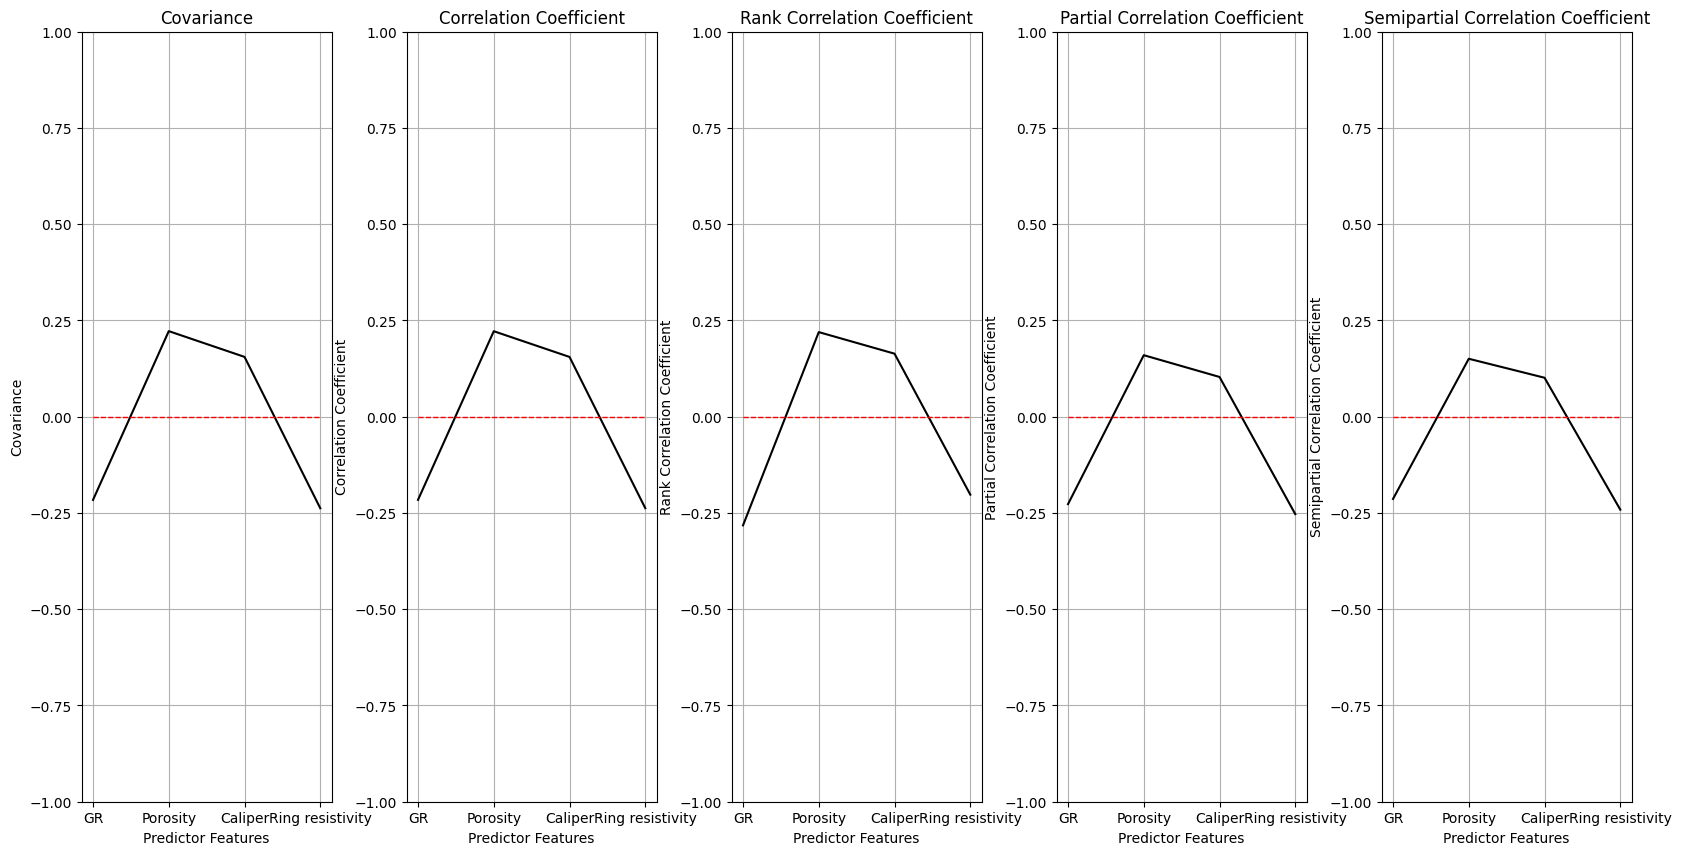

In [80]:
#Comparing different methods of feature ranking for MLT2

features = dfS.columns.values[1:][:4]

plt.subplot(151)
plt.plot(features,covariance1,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Covariance')
t = plt.title('Covariance')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(152)
plt.plot(features,correlation1,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Correlation Coefficient')
t = plt.title('Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(153)
plt.plot(features,rank_correlation1,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(154)
plt.plot(features,partial_correlation1,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(155)
plt.plot(features,semipartial_correlation1,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.gcf().set_size_inches(20, 10)
plt.show()

C:\Users\amale\AppData\Local\Temp\ipykernel_5040\3378805789.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
C:\Users\amale\AppData\Local\Temp\ipykernel_5040\3378805789.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
C:\Users\amale\AppData\Local\Temp\ipykernel_5040\3378805789.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
C:\Users\amale\AppData\Local\Temp\ipykernel_5040\3378805789.py:33: UserWarning: color is redundantly defined by the 'color' keyword ar

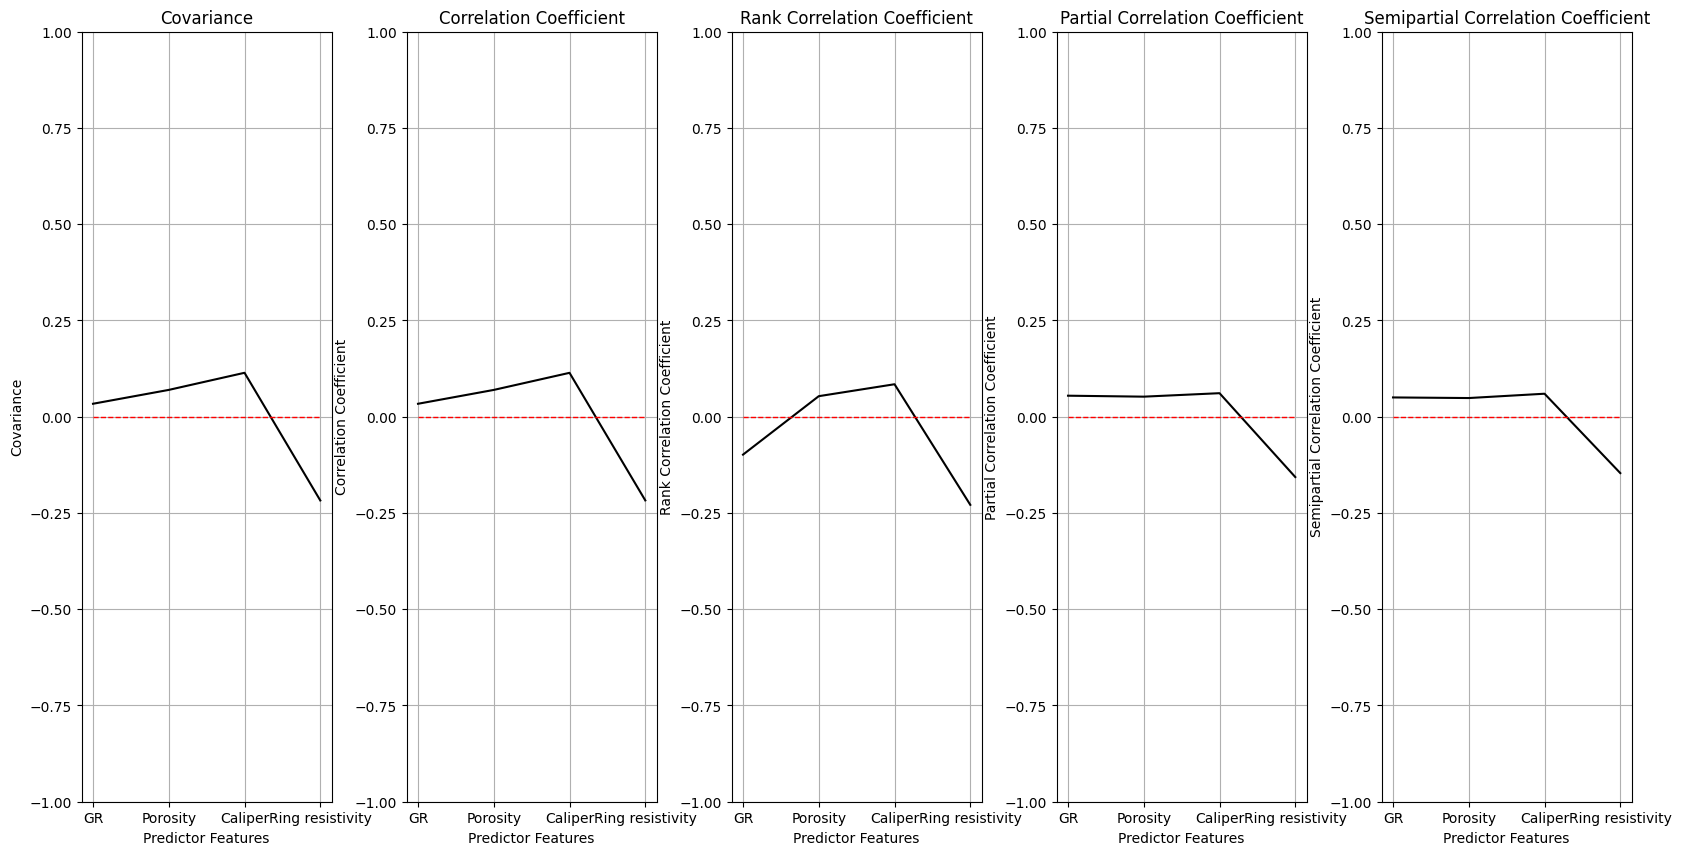

In [81]:
#Comparing different methods of feature ranking for SDT2

features = dfS.columns.values[1:][:4]
plt.subplot(151)
plt.plot(features,covariance2,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Covariance')
t = plt.title('Covariance')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(152)
plt.plot(features,correlation2,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Correlation Coefficient')
t = plt.title('Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(153)
plt.plot(features,rank_correlation2,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(154)
plt.plot(features,partial_correlation2,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(155)
plt.plot(features,semipartial_correlation2,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.gcf().set_size_inches(20, 10)
plt.show()

[0.34797762 0.28211748 0.20298991 0.16691499]


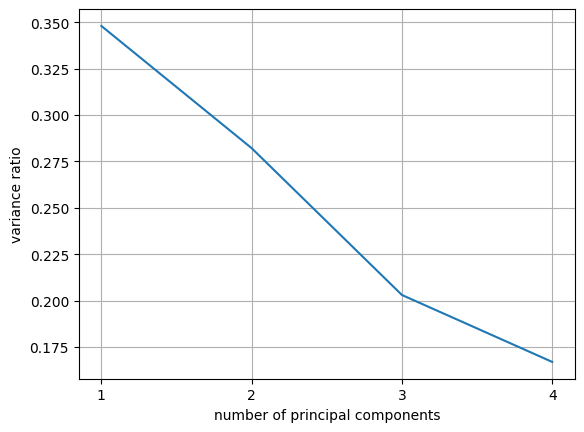

In [82]:
pca1 = PCA(n_components=4)
dfS1 = dfS.iloc[:,[1,2,3,4]] # all predictors

pca1.fit(dfS1)
#print(pca1.components_)
print(pca1.explained_variance_ratio_)
plt.plot(range(1,5), pca1.explained_variance_ratio_)
plt.xlabel("number of principal components")
plt.ylabel("variance ratio")
plt.xticks(np.arange(1,5,1))
plt.grid(True)

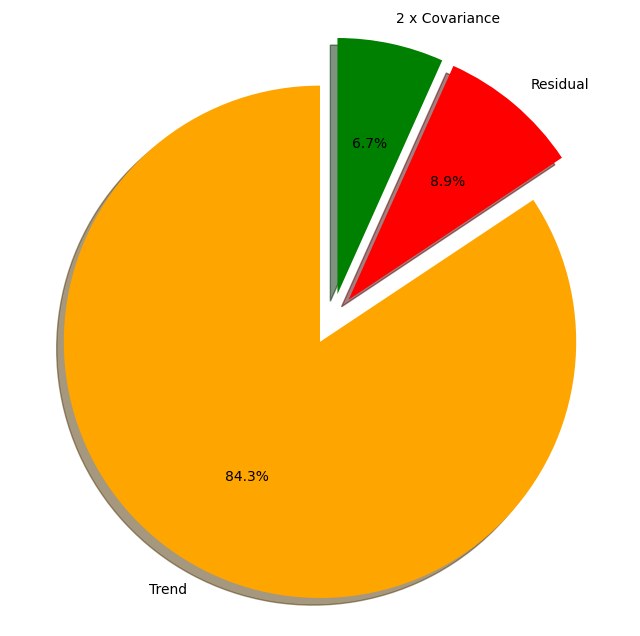

In [83]:
window_size = 21                        # assume window size in depth 3 m (Reduced vertical resolution to get better prediction)
                                        #Window size affecting R2.
#Determing rolling statistics
dfR = dfS.rolling(window = window_size, center = True).mean()

dfW = pd.DataFrame()
dfW['rolling_mean'] = dfR['GR'].values
dfW['residual'] = dfS['GR'].values - dfR['GR'].values
variance = np.var(dfS['GR'])
variance_trend = np.var(dfW['rolling_mean'])
variance_residual = np.var(dfW['residual'])
prop_trend = variance_trend/variance
prop_resid = variance_residual/variance
prop_cov = 1 - prop_trend - prop_resid
variance_prop = [prop_trend, prop_resid, prop_cov]
labels = 'Trend', 'Residual', '2 x Covariance'
colors = 'orange', 'red', 'green'
explode = (0.1, 0.1,0.1)
fig1, ax1 = plt.subplots()
ax1.pie(variance_prop, explode=explode, colors = colors, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.gcf().set_size_inches(8, 8)
plt.show()

In [84]:
# Remove NaN values introduced during the rolling progress
dfS=dfR
dfS=dfS.dropna()
dfS.describe()

,Depth,GR,Porosity,Caliper,Ring resistivity,MLT2_all_original,SD_all_original
count,1293.000000,1293.000000,1293.000000,1293.000000,1293.000000,1293.000000,1293.000000
mean,110.162400,0.017508,0.007507,0.004264,0.008906,-0.023089,0.000186
std,56.906352,0.918755,0.623414,0.721358,0.799865,0.860855,0.816772
min,11.712000,-2.736318,-1.431753,-1.004774,-1.984587,-1.900191,-2.059053
25%,60.937200,0.130400,-0.398589,-0.461254,-0.724852,-0.525810,-0.593979
50%,110.162400,0.325732,-0.053180,-0.076489,0.287870,-0.018782,-0.061629
75%,159.387600,0.483643,0.455277,0.273782,0.597912,0.523552,0.595148
max,208.612800,0.908984,2.016654,3.436449,1.440593,2.988851,1.905221


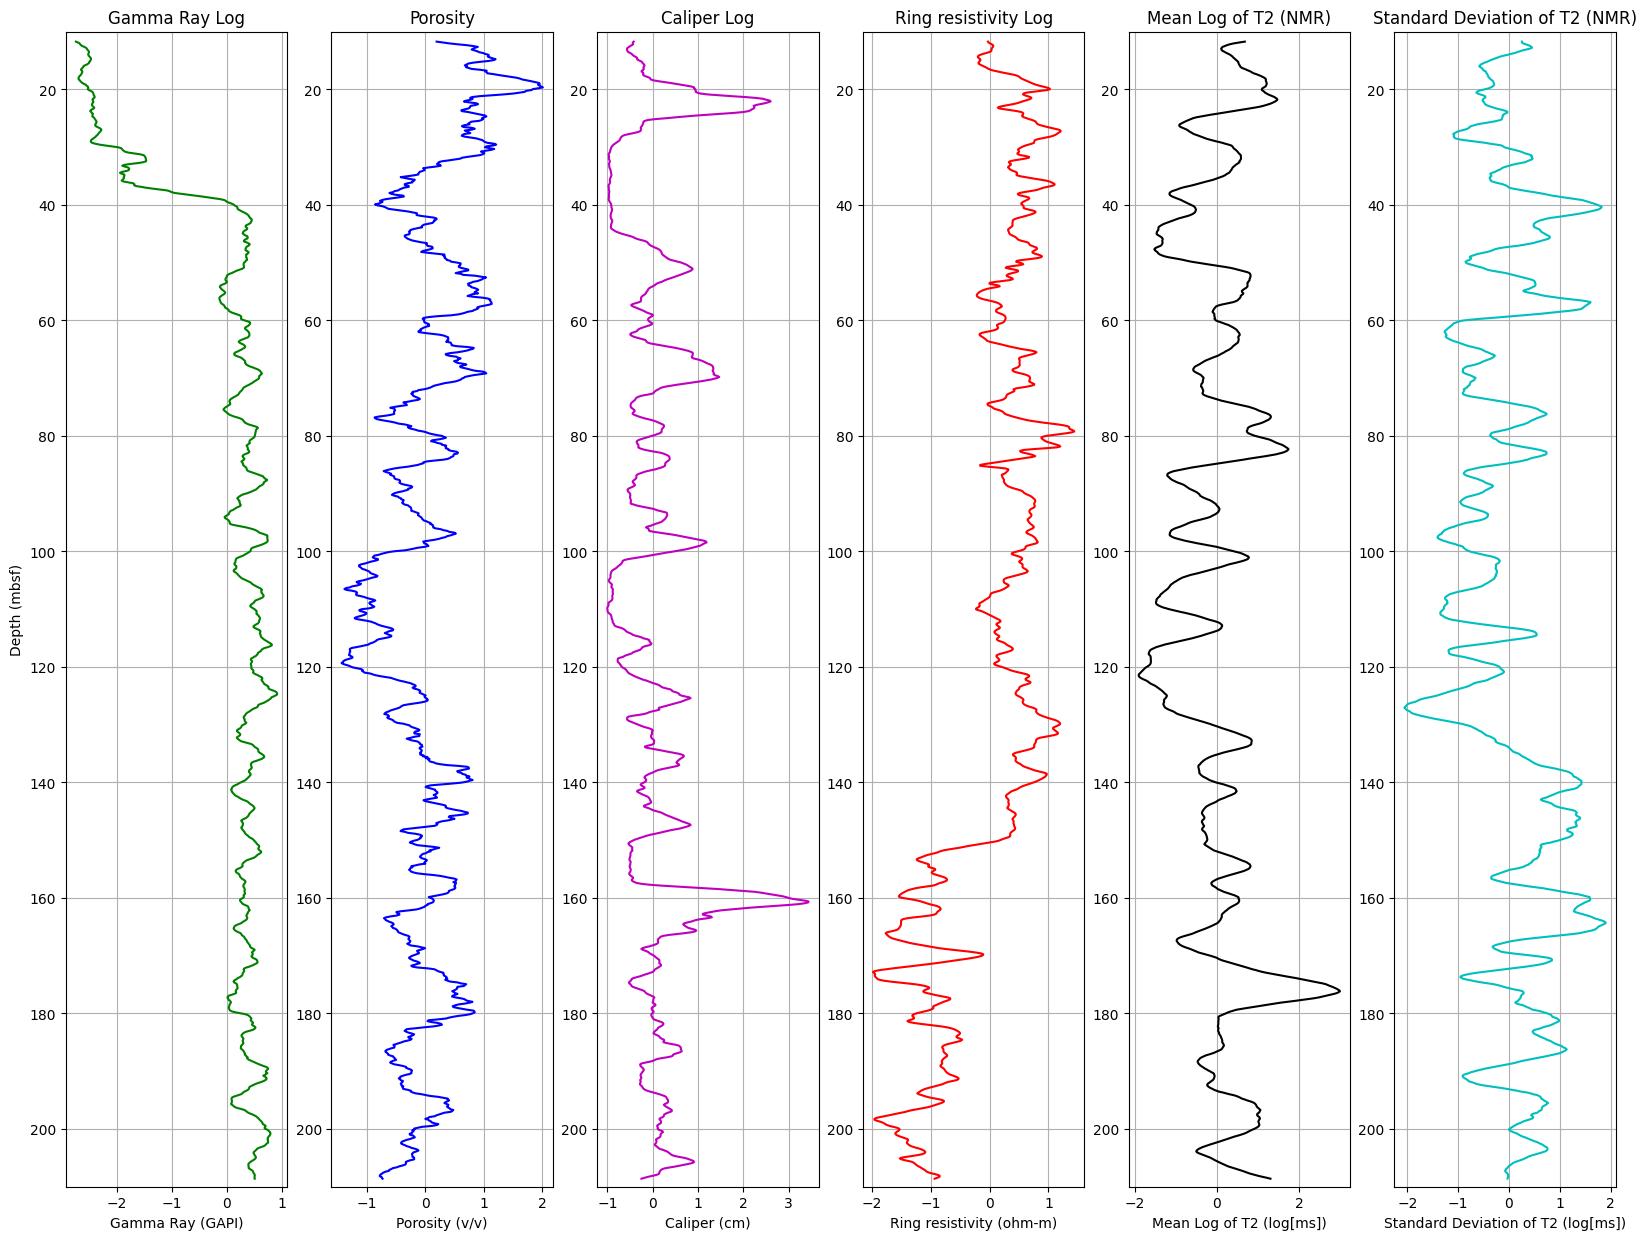

In [86]:
# Plot logs vs depth
plt.subplot(161)
plt.plot(dfR['GR'].values, dfR['Depth'].values,'g')
#plt.yscale('linear')
plt.title(grtitle)
plt.xlabel(grname)
plt.ylabel(depthname)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.ylim((10,210))
plt.gca().invert_yaxis()

plt.subplot(162)
plt.plot(dfR['Porosity'].values, dfR['Depth'].values,'b')
#plt.yscale('linear')
plt.title(portitle)
plt.xlabel(porname)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.ylim((10,210))
plt.gca().invert_yaxis()

plt.subplot(163)
plt.plot(dfR['Caliper'].values, dfR['Depth'].values,'m')
#plt.yscale('linear')
plt.title(caltitle)
plt.xlabel(calname)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.ylim((10,210))
plt.gca().invert_yaxis()

plt.subplot(164)
plt.plot(dfR['Ring resistivity'].values, dfR['Depth'].values,'r')
#plt.yscale('linear')
plt.title(restitle)
plt.xlabel(resname)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.ylim((10,210))
plt.gca().invert_yaxis()

plt.subplot(165)
plt.plot(dfR['MLT2_all_original'].values, dfR['Depth'].values,'k')
#plt.yscale('linear')
plt.title(mlt2title)
plt.xlabel(mlt2name)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.ylim((10,210))
plt.gca().invert_yaxis()

plt.subplot(166)
plt.plot(dfR['SD_all_original'].values, dfR['Depth'].values,'c')
#plt.yscale('linear')
plt.title(sdt2title)
plt.xlabel(sdt2name)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.ylim((10,210))
plt.gca().invert_yaxis()

plt.gcf().set_size_inches(20, 15)

In [87]:
#Train-Test split
X_train, X_test, Y_train, Y_test = train_test_split(dfS.iloc[:,[0,1,2,3,4]],dfS.iloc[:,[0,5,6]], test_size=0.2)
print('Number of training data = ' + str(len(X_train)) + ' and number of testing data = ' + str(len(X_test)))
print('Total number of data = ' + str(len(dfS.iloc[:,[0]])))

Number of training data = 1034 and number of testing data = 259
Total number of data = 1293


In [88]:
# Sort according to depth for plotting
X_train.sort_values(by=['Depth'], inplace=True)
Y_train.sort_values(by=['Depth'], inplace=True)
X_test.sort_values(by=['Depth'], inplace=True)
Y_test.sort_values(by=['Depth'], inplace=True)
#X_train.head()

In [92]:
import numpy as np
import pandas as pd
import scipy.special

# Define Hermite polynomial orders
orders3 = [0, 1, 2, 3]

# Ensure all input variables are numeric and explicitly cast to float
for col in ['GR', 'Porosity', 'Caliper', 'Ring resistivity']:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce').fillna(0).astype(float)

# Evaluate Hermite polynomials
def evaluate_hermite(order_list, data):
    """Evaluates Hermite polynomials for each order on the input data."""
    results = []
    for order in order_list:
        results.append(scipy.special.eval_hermitenorm(order, data))
    return np.column_stack(results)

# Apply the function to each variable
hermite_GR = evaluate_hermite(orders3, X_train['GR'].values)
hermite_Porosity = evaluate_hermite(orders3, X_train['Porosity'].values)
hermite_Caliper = evaluate_hermite(orders3, X_train['Caliper'].values)
hermite_Resistivity = evaluate_hermite(orders3, X_train['Ring resistivity'].values)

# Create a DataFrame dynamically for Hermite polynomials
df_hermite = pd.DataFrame({
    'const': hermite_GR[:, 0],  # Add constant term from GR
    'GR1': hermite_GR[:, 1], 'GR2': hermite_GR[:, 2], 'GR3': hermite_GR[:, 3],
    'Por1': hermite_Porosity[:, 1], 'Por2': hermite_Porosity[:, 2], 'Por3': hermite_Porosity[:, 3],
    'Cal1': hermite_Caliper[:, 1], 'Cal2': hermite_Caliper[:, 2], 'Cal3': hermite_Caliper[:, 3],
    'Res1': hermite_Resistivity[:, 1], 'Res2': hermite_Resistivity[:, 2], 'Res3': hermite_Resistivity[:, 3]
})

# Display the first few rows of the Hermite DataFrame
print(df_hermite.head(10))


   const       GR1       GR2        GR3      Por1      Por2      Por3  \
0    1.0 -2.736318  6.487435 -12.279048  0.195986 -0.961589 -0.580431   
1    1.0 -2.697717  6.277675 -11.539954  0.303154 -0.908098 -0.881600   
2    1.0 -2.669422  6.125816 -11.013545  0.412359 -0.829960 -1.166960   
3    1.0 -2.658426  6.067231 -10.812433  0.548376 -0.699284 -1.480222   
4    1.0 -2.580713  5.660080  -9.445616  0.903072 -0.184460 -1.972726   
5    1.0 -2.554978  5.527915  -9.013747  0.855415 -0.268265 -1.940308   
6    1.0 -2.535653  5.429534  -8.696106  0.826505 -0.316889 -1.914921   
7    1.0 -2.530280  5.402315  -8.608810  0.795948 -0.366466 -1.883585   
8    1.0 -2.512869  5.314509  -8.328925  0.844557 -0.286723 -1.931269   
9    1.0 -2.502207  5.261040  -8.159798  0.895010 -0.198956 -1.968089   

       Cal1      Cal2      Cal3      Res1      Res2      Res3  
0 -0.420587 -0.823106  1.187362 -0.027626 -0.999237  0.082857  
1 -0.442766 -0.803959  1.241497 -0.018362 -0.999663  0.055080  
2 -0

In [93]:
#Covariance comparison between variables Training
df_hermite.iloc[:,0:].corr()

,const,GR1,GR2,GR3,Por1,Por2,Por3,Cal1,Cal2,Cal3,Res1,Res2,Res3
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GR1,NaN,1.000000,-0.939151,0.713588,-0.535535,-0.408964,0.393362,0.050903,-0.153893,-0.141192,-0.237296,0.140829,0.211969
GR2,NaN,-0.939151,1.000000,-0.889377,0.502031,0.455752,-0.341015,0.004230,0.140287,0.102940,0.209125,-0.123049,-0.191524
GR3,NaN,0.713588,-0.889377,1.000000,-0.428171,-0.470800,0.257011,-0.114175,-0.091456,-0.035378,-0.118198,0.087540,0.101415
Por1,NaN,-0.535535,0.502031,-0.428171,1.000000,0.130271,-0.887136,0.315732,0.079469,-0.080947,0.098445,0.024221,-0.118378
Por2,NaN,-0.408964,0.455752,-0.470800,0.130271,1.000000,0.078342,-0.126920,0.026539,0.017528,0.196516,-0.241794,-0.160843
Por3,NaN,0.393362,-0.341015,0.257011,-0.887136,0.078342,1.000000,-0.282550,-0.103394,0.028792,-0.071729,0.001328,0.091776
Cal1,NaN,0.050903,0.004230,-0.114175,0.315732,-0.126920,-0.282550,1.000000,0.624262,0.150996,-0.188783,0.248390,0.116590
Cal2,NaN,-0.153893,0.140287,-0.091456,0.079469,0.026539,-0.103394,0.624262,1.000000,0.794629,-0.083906,0.065260,0.060911
Cal3,NaN,-0.141192,0.102940,-0.035378,-0.080947,0.017528,0.028792,0.150996,0.794629,1.000000,-0.067158,-0.011448,0.097494


In [95]:
import numpy as np
import pandas as pd
import scipy.special

# Define Hermite polynomial orders
orders3 = [0, 1, 2, 3]

# Ensure all input variables in X_test are numeric and explicitly cast to float
for col in ['GR', 'Porosity', 'Caliper', 'Ring resistivity']:
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce').fillna(0).astype(float)

# Evaluate Hermite polynomials for each variable
def evaluate_hermite(order_list, data):
    """Evaluates Hermite polynomials for each order on the input data."""
    results = []
    for order in order_list:
        results.append(scipy.special.eval_hermitenorm(order, data))
    return np.column_stack(results)

# Apply the function to each variable in X_test
hermite_GR = evaluate_hermite(orders3, X_test['GR'].values)
hermite_Porosity = evaluate_hermite(orders3, X_test['Porosity'].values)
hermite_Caliper = evaluate_hermite(orders3, X_test['Caliper'].values)
hermite_Resistivity = evaluate_hermite(orders3, X_test['Ring resistivity'].values)

# Create a DataFrame dynamically for Hermite polynomials (Testing set)
df_hermite_test = pd.DataFrame({
    'const': hermite_GR[:, 0],  # Add constant term from GR
    'GR1': hermite_GR[:, 1], 'GR2': hermite_GR[:, 2], 'GR3': hermite_GR[:, 3],
    'Por1': hermite_Porosity[:, 1], 'Por2': hermite_Porosity[:, 2], 'Por3': hermite_Porosity[:, 3],
    'Cal1': hermite_Caliper[:, 1], 'Cal2': hermite_Caliper[:, 2], 'Cal3': hermite_Caliper[:, 3],
    'Res1': hermite_Resistivity[:, 1], 'Res2': hermite_Resistivity[:, 2], 'Res3': hermite_Resistivity[:, 3]
})

# Display the first few rows of the Hermite DataFrame
print(df_hermite_test.head())

# Covariance comparison between variables (Testing set)
correlation_matrix = df_hermite_test.corr()
print(correlation_matrix)


   const       GR1       GR2        GR3      Por1      Por2      Por3  \
0    1.0 -2.643987  5.990670 -10.551281  0.706742 -0.500516 -1.767219   
1    1.0 -2.620488  5.866955 -10.133309  0.818998 -0.329243 -1.907645   
2    1.0 -2.498174  5.240875  -8.096272  0.924747 -0.144844 -1.983437   
3    1.0 -2.463721  5.069921  -7.563429  1.156730  0.338025 -1.922457   
4    1.0 -2.460514  5.054131  -7.514734  1.206762  0.456273 -1.862910   

       Cal1      Cal2      Cal3      Res1      Res2      Res3  
0 -0.461254 -0.787245  1.285628  0.057741 -0.996666 -0.173032  
1 -0.499171 -0.750829  1.373133  0.062503 -0.996093 -0.187266  
2 -0.536850 -0.711792  1.455826 -0.011436 -0.999869  0.034306  
3 -0.343280 -0.882159  0.989387 -0.180699 -0.967348  0.536197  
4 -0.346863 -0.879686  0.998856 -0.162258 -0.973672  0.482501  
       const       GR1       GR2       GR3      Por1      Por2      Por3  \
const    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
GR1      NaN  1.000000 -0

In [96]:
#Training MLT2
lin_herm = LinearRegression() 
lin_herm.fit(df_hermite.iloc[:,0:], Y_train['MLT2_all_original']) 
MLT2_herm_pred=lin_herm.predict(df_hermite)

MLT2_poly_pred= mlt2mean+(MLT2_herm_pred*mlt2sd) #Remove standardization
MLT2_S= mlt2mean+(Y_train['MLT2_all_original'].values*mlt2sd) #Remove standardization
print('Coefficient of regression (R2) for MLT2 Training')
r2_score(MLT2_S, MLT2_poly_pred)

Coefficient of regression (R2) for MLT2 Training


0.4113629389517557

In [97]:
#Training SDT2
lin_herm2 = LinearRegression() 
lin_herm2.fit(df_hermite.iloc[:,0:], Y_train['SD_all_original']) 
SDT2_herm_pred=lin_herm2.predict(df_hermite)

SDT2_poly_pred= sdt2mean+(SDT2_herm_pred*sdt2sd) #Remove standardization
SDT2_S= sdt2mean+(Y_train['SD_all_original'].values*sdt2sd) #Remove standardization
print('Coefficient of regression (R2) for SDT2 Training')
r2_score(SDT2_S, SDT2_poly_pred)

Coefficient of regression (R2) for SDT2 Training


0.30347873379679813

In [98]:
#Testing MLT2
MLT2_herm_pred_test=lin_herm.predict(df_hermite_test)
MLT2_poly_pred_test= mlt2mean+(MLT2_herm_pred_test*mlt2sd) #Remove standardization
MLT2_S_test= mlt2mean+(Y_test['MLT2_all_original'].values*mlt2sd) #Remove standardization
print('Coefficient of regression (R2) for MLT2 Testing')
r2_score(MLT2_S_test, MLT2_poly_pred_test)

Coefficient of regression (R2) for MLT2 Testing


0.4318556460285954

In [99]:
#Testing SDT2
SDT2_herm_pred_test=lin_herm2.predict(df_hermite_test)
SDT2_poly_pred_test= sdt2mean+(SDT2_herm_pred_test*sdt2sd) #Remove standardization
SDT2_S_test= sdt2mean+(Y_test['SD_all_original'].values*sdt2sd) #Remove standardization
print('Coefficient of regression (R2) for SDT2 Testing')
r2_score(SDT2_S_test, SDT2_poly_pred_test)

Coefficient of regression (R2) for SDT2 Testing


0.21981877017527895

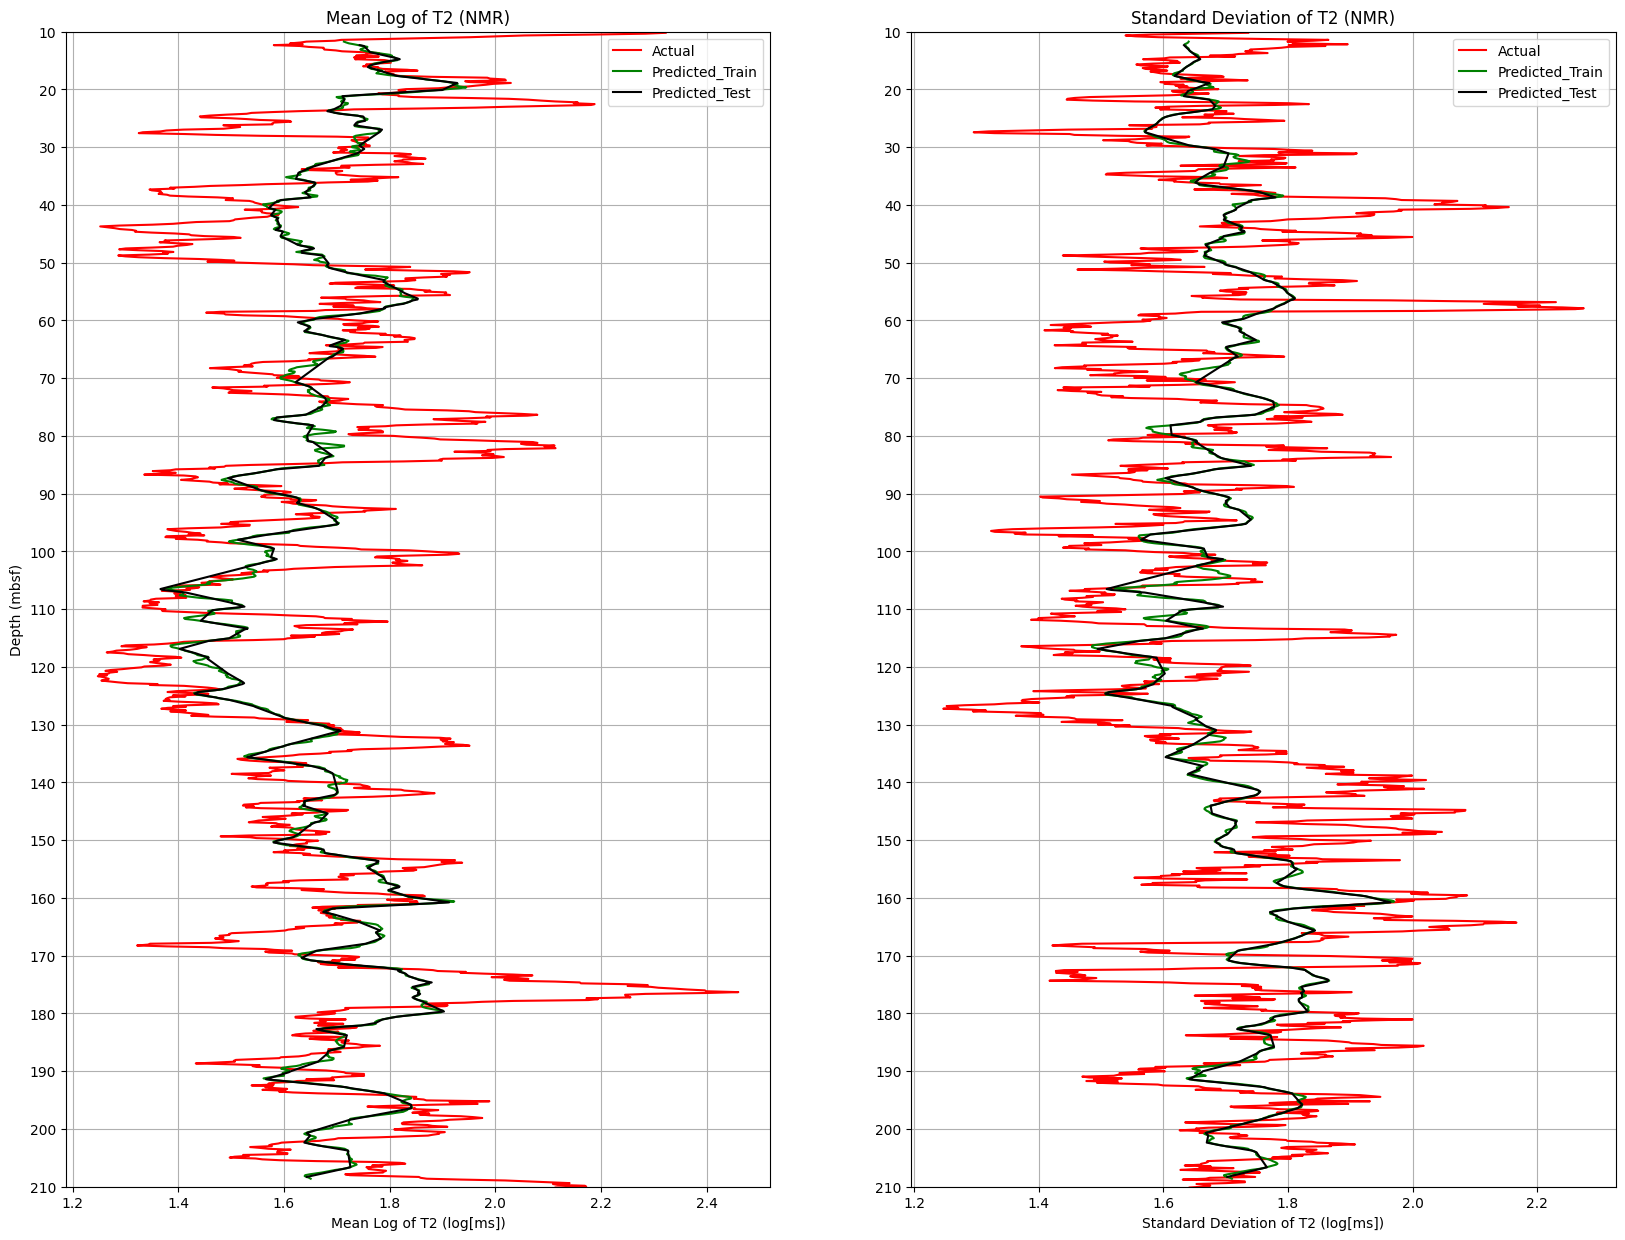

In [102]:
#Actual data comparison with train and test predictions

plt.subplot(121)
plt.plot(df['MLT2_all_original'].values, df['Depth'].values,'r',label='Actual')
plt.plot(MLT2_poly_pred, Y_train['Depth'].values,'g',label='Predicted_Train')
plt.plot(MLT2_poly_pred_test, Y_test['Depth'].values,'k',label='Predicted_Test')
plt.title(mlt2title)
plt.xlabel(mlt2name)
plt.ylabel(depthname)
plt.yticks(np.arange(0, max(df['Depth'].values), 10.0))
plt.grid(True)
plt.gca().set_ylim([10,210])
plt.gca().invert_yaxis()
plt.legend()

plt.subplot(122)
plt.plot(df['SD_all_original'].values, df['Depth'].values,'r',label='Actual')
plt.plot(SDT2_poly_pred, Y_train['Depth'].values,'g',label='Predicted_Train')
plt.plot(SDT2_poly_pred_test, Y_test['Depth'].values,'k',label='Predicted_Test')
plt.title(sdt2title)
plt.xlabel(sdt2name)
plt.yticks(np.arange(0, max(df['Depth'].values), 10.0))
plt.grid(True)
plt.gca().set_ylim([10,210])
plt.gca().invert_yaxis()
plt.legend()

plt.gcf().set_size_inches(20, 15)

In [107]:
# Load WR data, smoothen it and remove data dissimilar to trained model.
at14_log_file_path = os.path.join(os.getcwd(), "AT_14_logs.csv") 
df_WR = pd.read_csv(at14_log_file_path)
df_WR = df_WR[df_WR['Depth'] < 800]  #remove all values > 800 mbsf as data is not similar to training data
df_WR = df_WR.rolling(window = 30, center = True).mean()
df_WR=df_WR.dropna()

In [108]:
df_WR.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Depth,1618.0,125.546500,71.204432,2.331100,63.938800,125.546500,187.154200,248.761900
GR,1618.0,85.823291,10.008179,54.925470,85.969907,89.575993,91.385092,94.386997
Porosity,1618.0,0.561768,0.011578,0.539678,0.553301,0.560878,0.567573,0.604081
Caliper,1618.0,8.846222,0.377833,8.465553,8.621533,8.709662,8.898991,10.481163
Ring resistivity,1618.0,0.637104,0.054984,0.500133,0.596214,0.628097,0.674159,0.823463


In [109]:
#Defining the minimum and maximum of variables for plotting figures

pormin = df_WR['Porosity'].min(); pormax = df_WR['Porosity'].max(); porname = 'Porosity (v/v)'; portitle = 'Porosity' # user specified min and max values, and labels for plotting
grmin = df_WR['GR'].min(); grmax = df_WR['GR'].max(); grname = 'Gamma Ray (GAPI)'; grtitle = 'Gamma Ray Log' 
calmin = df_WR['Caliper'].min(); calmax = df_WR['Caliper'].max(); calname = 'Caliper (cm)'; caltitle = 'Caliper Log' 
resmin = df_WR['Ring resistivity'].min(); resmax = df_WR['Ring resistivity'].max(); resname = 'Ring resistivity (ohm-m)'; restitle = 'Ring resistivity Log' 
depthmin = df_WR['Depth'].min(); depthmax = df_WR['Depth'].max(); depthname = 'Depth (mbsf)'; depthtitle = 'Depth in meters below sea-floor (mbsf)' 


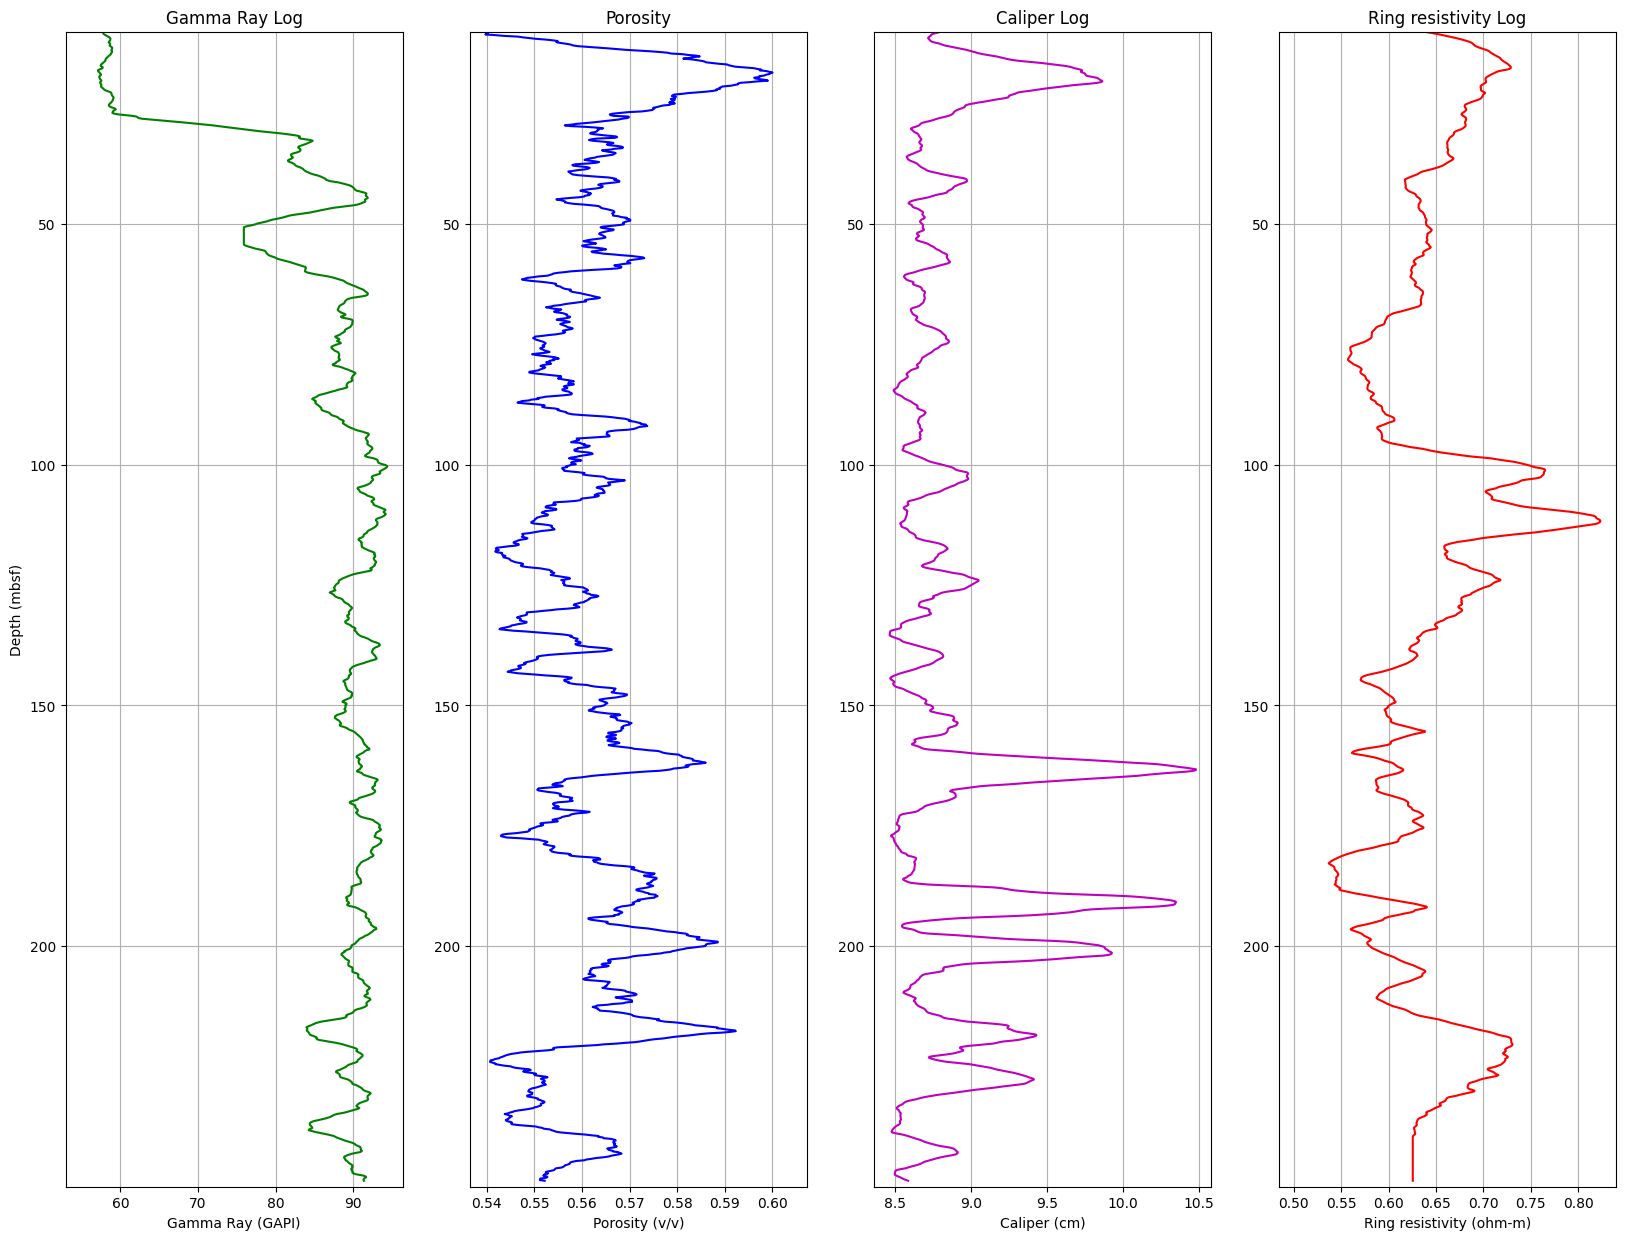

In [114]:
# Plot logs vs depth

plt.subplot(141)
plt.plot(df_WR['GR'].values, df_WR['Depth'].values,'g')
#plt.yscale('linear')
plt.title(grtitle)
plt.xlabel(grname)
plt.ylabel(depthname)
plt.yticks(np.arange(0, depthmax, 50.0))
plt.grid(True)
plt.gca().set_ylim([10,250])
plt.gca().invert_yaxis()

plt.subplot(142)
plt.plot(df_WR['Porosity'].values, df_WR['Depth'].values,'b')
#plt.yscale('linear')
plt.title(portitle)
plt.xlabel(porname)
plt.yticks(np.arange(0, depthmax, 50.0))
plt.grid(True)
plt.gca().set_ylim([10,250])
plt.gca().invert_yaxis()

plt.subplot(143)
plt.plot(df_WR['Caliper'].values, df_WR['Depth'].values,'m')
#plt.yscale('linear')
plt.title(caltitle)
plt.xlabel(calname)
plt.yticks(np.arange(0, depthmax, 50.0))
plt.grid(True)
plt.gca().set_ylim([10,250])
plt.gca().invert_yaxis()

plt.subplot(144)
plt.plot(df_WR['Ring resistivity'].values, df_WR['Depth'].values,'r')
#plt.xscale('log')
plt.title(restitle)
plt.xlabel(resname)
plt.yticks(np.arange(0, depthmax, 50.0))
plt.grid(True)
plt.gca().set_ylim([10,250])
plt.gca().invert_yaxis()


plt.gcf().set_size_inches(20, 15)

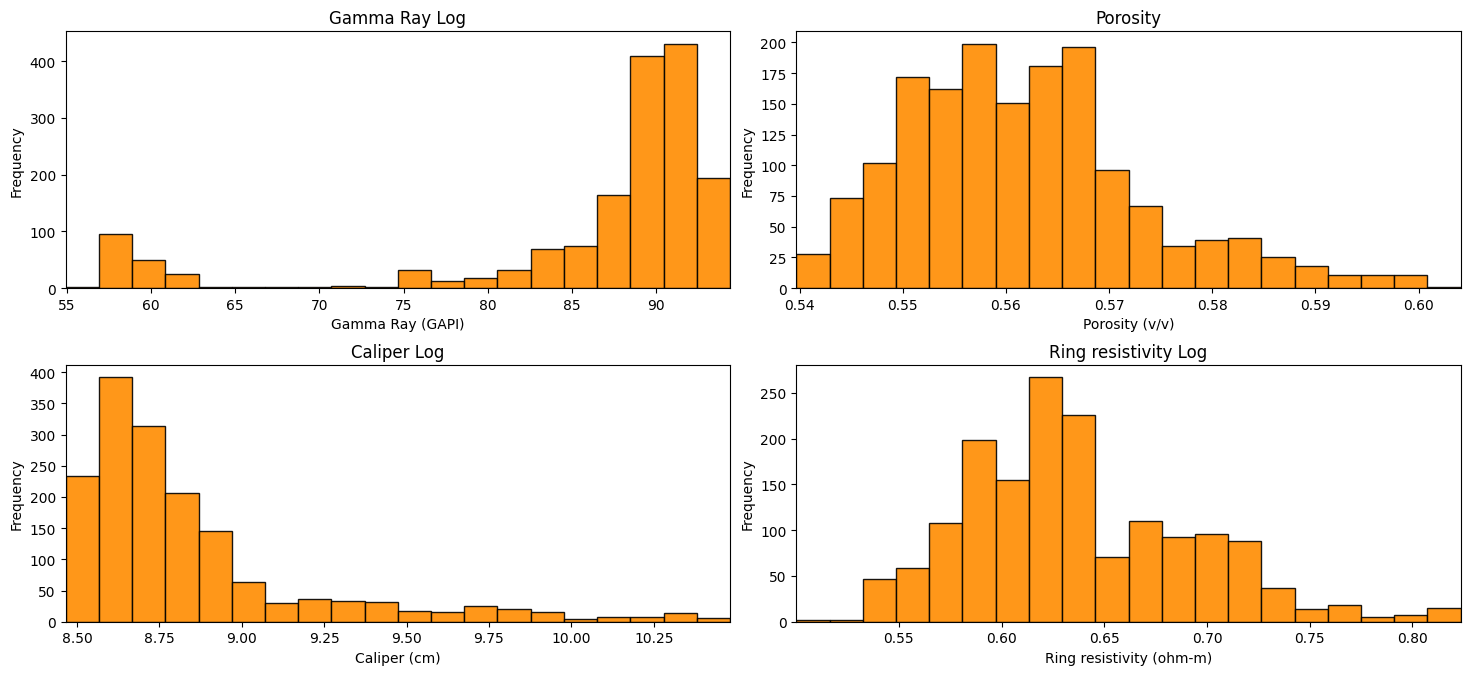

In [115]:
#Plotting univariate distributions

plt.subplot(321)
GSLIB.hist_st(df_WR['GR'].values, grmin, grmax, log=False, cumul = False,bins=20, weights = None, xlabel=grname, title=grtitle)

plt.subplot(322)
GSLIB.hist_st(df_WR['Porosity'].values,pormin,pormax,log=False,cumul = False,bins=20,weights = None,xlabel=porname,title=portitle)

plt.subplot(323)
GSLIB.hist_st(df_WR['Caliper'].values,calmin,calmax,log=False,cumul = False,bins=20,weights = None,xlabel=calname,title=caltitle)

plt.subplot(324)
GSLIB.hist_st(df_WR['Ring resistivity'].values,resmin,resmax,log=False,cumul = False,bins=20,weights = None, xlabel=resname, title=restitle)

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.gcf().set_size_inches(18, 12)
plt.show()

Plotting univariate distributions

It can be observed that the logs have been smoothened which will improve the regression fit.

In [116]:
#Standardization

dfS_WR = df_WR.copy()
depth=df_WR['Depth']
#scaler.fit(dfS_WR.drop('Depth',axis=1))
dfS1_WR = scaler.fit_transform(dfS_WR.drop('Depth', axis = 1)) # standardize all the values extracted from the DataFrame except Depth

dfS_WR = pd.DataFrame(dfS1_WR, index = dfS_WR.index, columns = dfS_WR.drop('Depth', axis = 1).columns)
dfS_WR.insert(0, 'Depth', depth)
dfS_WR.describe()

,Depth,GR,Porosity,Caliper,Ring resistivity
count,1618.000000,1.618000e+03,1.618000e+03,1.618000e+03,1.618000e+03
mean,125.546500,-7.026381e-16,-4.786722e-15,4.918466e-16,1.036391e-15
std,71.204432,1.000309e+00,1.000309e+00,1.000309e+00,1.000309e+00
min,2.331100,-3.088212e+00,-1.908484e+00,-1.007817e+00,-2.491889e+00
25%,63.938800,1.465410e-02,-7.314707e-01,-5.948617e-01,-7.439015e-01
50%,125.546500,3.750795e-01,-7.690104e-02,-3.615430e-01,-1.638668e-01
75%,187.154200,5.558974e-01,5.015068e-01,1.397036e-01,6.741431e-01
max,248.761900,8.559353e-01,3.655691e+00,4.328485e+00,3.390417e+00


In [119]:
import numpy as np
import pandas as pd
import scipy.special

# Define Hermite polynomial orders
orders3 = [0, 1, 2, 3]

# Ensure all input variables in dfS_WR are numeric and explicitly cast to float
for col in ['GR', 'Porosity', 'Caliper', 'Ring resistivity']:
    dfS_WR[col] = pd.to_numeric(dfS_WR[col], errors='coerce').fillna(0).astype(float)

# Define a function to evaluate Hermite polynomials for a given variable
def evaluate_hermite(order_list, data):
    """Evaluates Hermite polynomials for each order on the input data."""
    results = []
    for order in order_list:
        results.append(scipy.special.eval_hermitenorm(order, data))
    return np.column_stack(results)

# Apply the function to each variable in dfS_WR
hermite_GR = evaluate_hermite(orders3, dfS_WR['GR'].values)
hermite_Porosity = evaluate_hermite(orders3, dfS_WR['Porosity'].values)
hermite_Caliper = evaluate_hermite(orders3, dfS_WR['Caliper'].values)
hermite_Resistivity = evaluate_hermite(orders3, dfS_WR['Ring resistivity'].values)

# Dynamically construct the Hermite polynomial DataFrame
df_hermite_WR = pd.DataFrame({
    'const': hermite_GR[:, 0],  # Constant term from GR
    'GR1': hermite_GR[:, 1], 'GR2': hermite_GR[:, 2], 'GR3': hermite_GR[:, 3],
    'Por1': hermite_Porosity[:, 1], 'Por2': hermite_Porosity[:, 2], 'Por3': hermite_Porosity[:, 3],
    'Cal1': hermite_Caliper[:, 1], 'Cal2': hermite_Caliper[:, 2], 'Cal3': hermite_Caliper[:, 3],
    'Res1': hermite_Resistivity[:, 1], 'Res2': hermite_Resistivity[:, 2], 'Res3': hermite_Resistivity[:, 3]
})

# Display the first few rows of the Hermite polynomial DataFrame
print(df_hermite_WR.head())


   const       GR1       GR2        GR3      Por1       Por2       Por3  \
0    1.0 -3.088212  8.537051 -20.187798  3.655691  12.364074  37.887846   
1    1.0 -2.896161  7.387749 -15.603787  3.251742   9.573829  24.628142   
2    1.0 -2.764506  6.642495 -12.834207  2.900127   7.410739  15.691833   
3    1.0 -2.692367  6.248842 -11.439442  2.578814   5.650284   9.413404   
4    1.0 -2.671719  6.138081 -11.055790  2.410981   4.812830   6.781682   

       Cal1      Cal2       Cal3      Res1      Res2      Res3  
0  3.298136  9.877702  25.981732 -2.491889  5.209512 -7.997748  
1  2.750371  6.564540  12.554179 -2.330882  4.433012 -5.671063  
2  2.262430  4.118590   4.793163 -2.170724  3.712043 -3.716373  
3  2.046104  3.186542   2.427788 -2.011658  3.046766 -2.105736  
4  1.920825  2.689568   1.324540 -1.869511  2.495070 -0.925538  


In [120]:
#Polynomial regression for MLT2 using all variables

MLT2_herm_pred_WR=lin_herm.predict(df_hermite_WR)
MLT2_poly_pred_WR= mlt2mean+(MLT2_herm_pred_WR*mlt2sd) #Remove standardization

df_pred_MLT2_WR = pd.DataFrame(data=MLT2_poly_pred_WR)  
#df_pred_MLT2_WR.describe()

In [121]:
#Polynomial regression for SDT2 using all variables

SDT2_herm_pred_WR=lin_herm2.predict(df_hermite_WR)
SDT2_poly_pred_WR= sdt2mean+(SDT2_herm_pred_WR*sdt2sd) #Remove standardization

df_pred_SDT2_WR = pd.DataFrame(data=SDT2_poly_pred_WR)  
#df_pred_SDT2_WR.describe()

### **Plotting Predicted Well Logs with Depth**  

The predicted values of **Mean of T2 (MLT2)** and **Standard Deviation of T2 (SDT2)** from the regression model are plotted against depth alongside the other well logs. The results show a consistent pattern with the observed logs. For instance, at depths with low Gamma Ray (GR) values around ~290 meters below seafloor (mbsf), the MLT2 exhibits an increase, while the SDT2 decreases. This behavior aligns with the presence of larger and more uniform pore sizes in the formation at those depths.

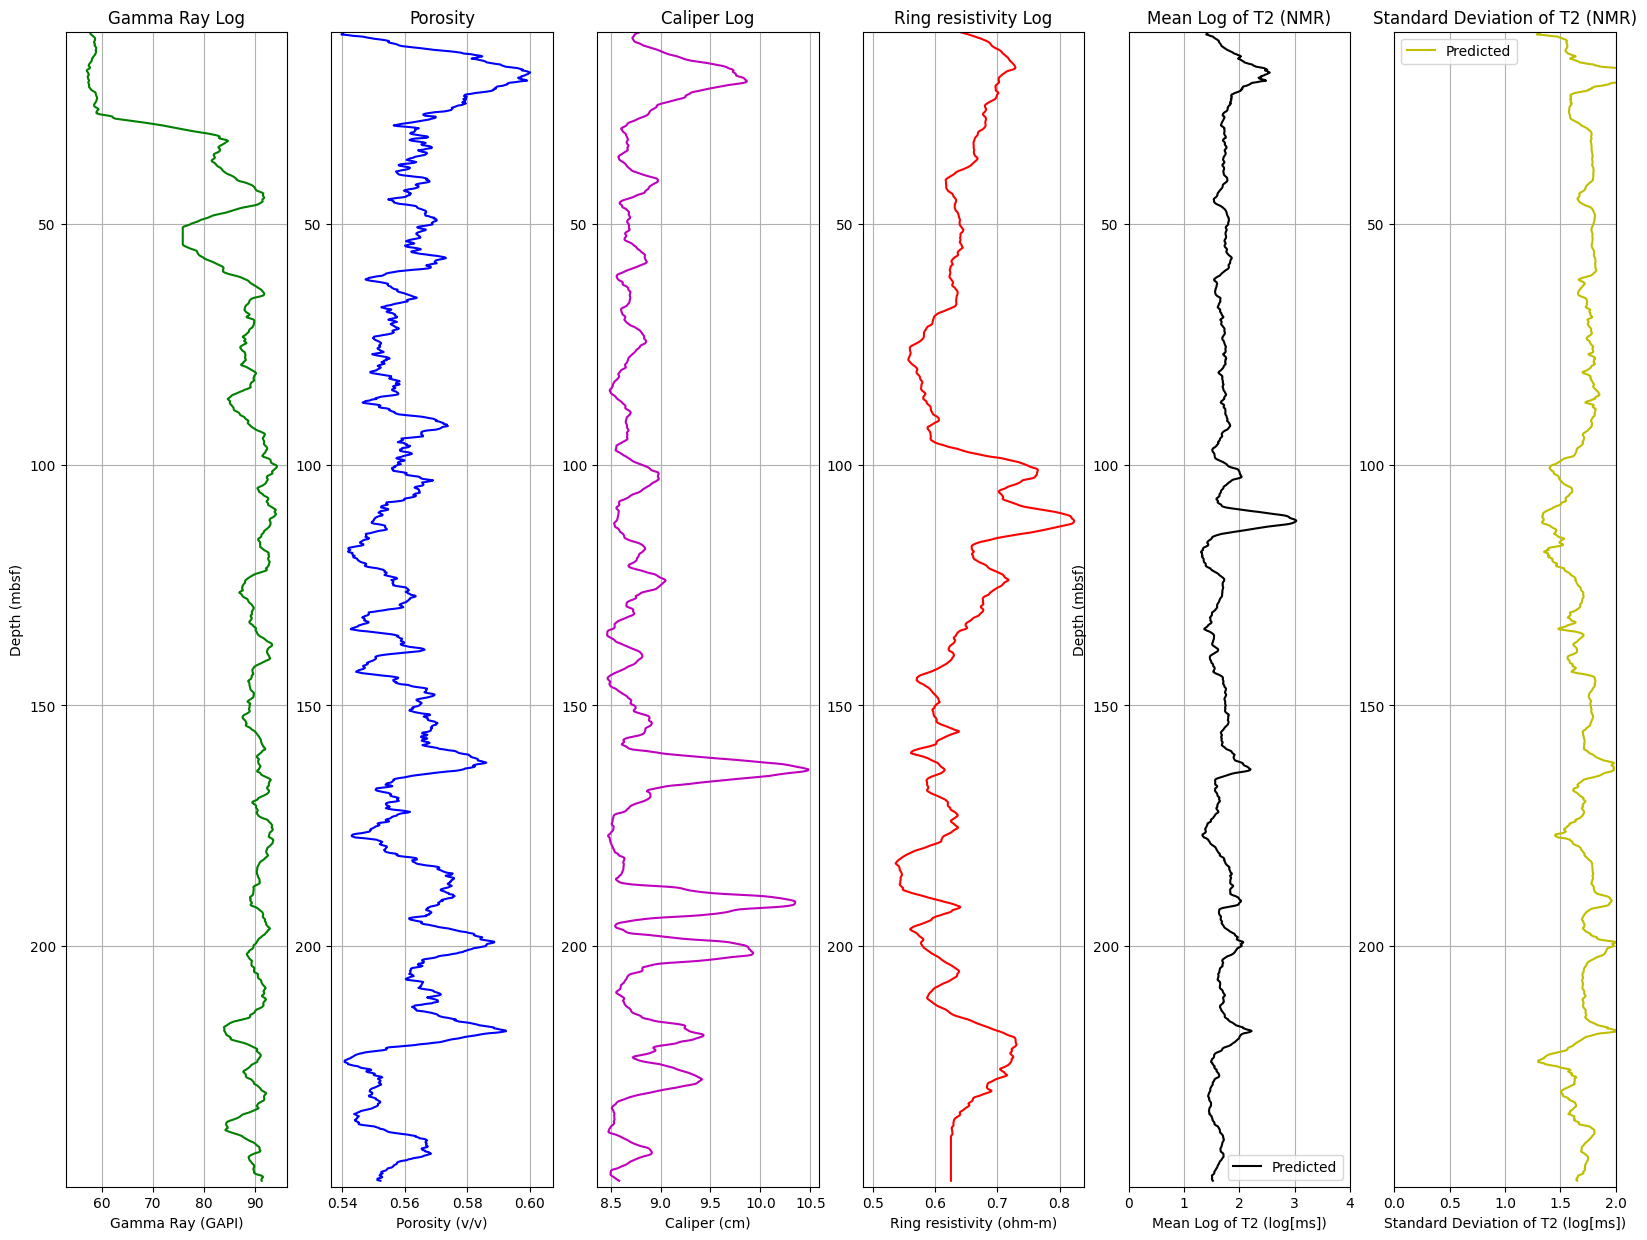

In [122]:
plt.subplot(161)
plt.plot(df_WR['GR'].values, df_WR['Depth'].values,'g')
#plt.yscale('linear')
plt.title(grtitle)
plt.xlabel(grname)
plt.ylabel(depthname)
plt.yticks(np.arange(0, depthmax, 50.0))
plt.grid(True)
plt.gca().set_ylim([10,250])
plt.gca().invert_yaxis()

plt.subplot(162)
plt.plot(df_WR['Porosity'].values, df_WR['Depth'].values,'b')
#plt.yscale('linear')
plt.title(portitle)
plt.xlabel(porname)
plt.yticks(np.arange(0, depthmax, 50.0))
plt.grid(True)
plt.gca().set_ylim([10,250])
plt.gca().invert_yaxis()

plt.subplot(163)
plt.plot(df_WR['Caliper'].values, df_WR['Depth'].values,'m')
#plt.yscale('linear')
plt.title(caltitle)
plt.xlabel(calname)
plt.yticks(np.arange(0, depthmax, 50.0))
plt.grid(True)
plt.gca().set_ylim([10,250])
plt.gca().invert_yaxis()

plt.subplot(164)
plt.plot(df_WR['Ring resistivity'].values, df_WR['Depth'].values,'r')
#plt.xscale('log')
plt.title(restitle)
plt.xlabel(resname)
plt.yticks(np.arange(0, depthmax, 50.0))
plt.grid(True)
plt.gca().set_ylim([10,250])
plt.gca().invert_yaxis()

plt.subplot(165)
plt.plot(MLT2_poly_pred_WR, dfS_WR['Depth'].values,'k',label='Predicted')
plt.title(mlt2title)
plt.xlabel(mlt2name)
plt.ylabel(depthname)
plt.yticks(np.arange(0, max(df_WR['Depth'].values), 50.0))
plt.grid(True)
plt.gca().set_ylim([10,250])
plt.gca().set_xlim([0,4])
plt.gca().invert_yaxis()
plt.legend()
plt.subplot(166)
plt.plot(SDT2_poly_pred_WR, dfS_WR['Depth'].values,'y',label='Predicted')
plt.title(sdt2title)
plt.xlabel(sdt2name)
plt.yticks(np.arange(0, max(df_WR['Depth'].values), 50.0))
plt.grid(True)
plt.gca().set_ylim([10,250])
plt.gca().set_xlim([0,2])
plt.gca().invert_yaxis()
plt.legend()

plt.gcf().set_size_inches(20, 15)

### Acknowledgement

I would like to acknowledge Abhishek D. Bihani for the original source code for the synthetic well log polynomial regression, available on GitHub (https://github.com/abhishekdbihani/synthetic_well-log_polynomial_regression ). I have made slight modifications to the code to suit the specific needs of my project.